In [1]:
from nlp_data_handle import *
from transformer_debugger import *

/anaconda/envs/py38_default/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
import argparse
import sys
import os
sys.argv = ['']
parser=argparse.ArgumentParser()
parser.add_argument('-expt_num',dest="expt_name",type=str,default="tempexp")
parser.add_argument('-num_samples',dest="num_samples",type=int,default=1000)
parser.add_argument('-num_topics',dest="num_topics",type=int,default=1)
parser.add_argument('-num_topic_samples',dest="num_topic_samples",type=int,default=None)
parser.add_argument('-num_cat',dest="num_cat",type=int,default=10)
parser.add_argument('-num_causal_nodes',dest="num_causal_nodes",type=int,default=1)
parser.add_argument('-num_child_nodes',dest="num_child_nodes",type=int,default=5)

parser.add_argument('-tfreq_ulim',dest="tfreq_ulim",type=float,default=1.0)
parser.add_argument('-transformer',dest="transformer",type=str,default="bert-base-uncased")
parser.add_argument('-num_epochs',dest="num_epochs",type=int,default=10)

parser.add_argument("-load_weight_exp",dest="load_weight_exp",type=str,default=None)
parser.add_argument("-load_weight_epoch",dest="load_weight_epoch",type=str,default=None)

parser.add_argument("-gate_weight_exp",dest="gate_weight_exp",type=str,default=None)
parser.add_argument("-gate_weight_epoch",dest="gate_weight_epoch",type=int,default=None)
parser.add_argument("-gate_var_cutoff",dest="gate_var_cutoff",type=float,default=1.0) #all will be allowed for this

parser.add_argument('--train_bert',default=False,action="store_true")

args=parser.parse_args()
print(args)

#Defining the Data args
data_args={}
data_args["path"] = "dataset/amazon/"
data_args["transformer_name"]=args.transformer
data_args["num_class"]=2
data_args["max_len"]=200
data_args["num_sample"]=args.num_samples
data_args["num_topic_samples"]=args.num_topic_samples
data_args["batch_size"]=64 #always keep small batch size#args.num_samples
data_args["shuffle_size"]=data_args["batch_size"]*3
data_args["cat_list"]=list(range(args.num_cat))#["arts","books","phones","clothes","groceries","movies","pets","tools"]
data_args["num_topics"]=args.num_topics
data_args["topic_list"]=list(range(data_args["num_topics"]))
data_args["per_topic_class"]=2 #Each of the topic is binary (later could have more)
data_args["tfreq_ulim"]=args.tfreq_ulim
data_args["lda_epochs"]=25
data_args["min_df"]=0.0
data_args["max_df"]=1.0
data_args["num_causal_nodes"]=args.num_causal_nodes
data_args["num_child_nodes"]=args.num_child_nodes

#Defining the Model args
model_args={}
model_args["expt_name"]=args.expt_name
data_args["expt_name"]=model_args["expt_name"]
model_args["load_weight_exp"]=args.load_weight_exp
model_args["load_weight_epoch"]=args.load_weight_epoch
model_args["lr"]=0.001
model_args["epochs"]=args.num_epochs
model_args["valid_split"]=0.2
model_args["train_bert"]=args.train_bert
model_args["bemb_dim"] = args.num_causal_nodes+args.num_child_nodes        #The dimension of bert produced last layer
model_args["shuffle_topic_batch"]=False
model_args["gate_weight_exp"]=args.gate_weight_exp
model_args["gate_weight_epoch"]=args.gate_weight_epoch
model_args["gate_var_cutoff"]=args.gate_var_cutoff

#Creating the metadata folder
meta_folder = "nlp_logs/{}".format(model_args["expt_name"])
os.makedirs(meta_folder,exist_ok=True)

Namespace(expt_name='tempexp', gate_var_cutoff=1.0, gate_weight_epoch=None, gate_weight_exp=None, load_weight_epoch=None, load_weight_exp=None, num_cat=10, num_causal_nodes=1, num_child_nodes=5, num_epochs=10, num_samples=1000, num_topic_samples=None, num_topics=1, tfreq_ulim=1.0, train_bert=False, transformer='bert-base-uncased')


In [42]:
def get_dim_std(data_args,model_args,num_cat,expt_name,load_weight_epoch):
    #Updating the category number
    data_args["cat_list"]=list(range(num_cat))
    
    #Getting the dataset for validation and loading the weight
    data_handler = DataHandleTransformer(data_args)
    all_cat_ds = data_handler.create_synthetic_dataset2()
    data_args["cat_list"] = data_handler.data_args["cat_list"]
    
    #Creating the classifier
    classifier = TransformerClassifier(data_args,model_args)
    classifier.compile(
        keras.optimizers.Adam(learning_rate=model_args["lr"])
    )
    #Loading the checkpoint
    checkpoint_path = "nlp_logs/{}/cp_{}.ckpt".format(expt_name,load_weight_epoch)
    checkpoint_dir = os.path.dirname(checkpoint_path)
    classifier.load_weights(checkpoint_path)
    
    #Get the gate tensor
    gate_tensor = get_dimension_gate(data_args,model_args)
    
    #Now running one trip of validation
    from collections import defaultdict
    ood_perf = defaultdict(list)
    for tidx,tname in enumerate(all_cat_ds.keys()):
        ood_perf["domain"].append(tname)
        for cidx,(cat,cat_ds) in enumerate(all_cat_ds.items()):
            #Evaluating the classifier and loading the weights
            classifier.sent_valid_acc_list[tidx].reset_state()
            print("RESET_VACC:",classifier.sent_valid_acc_list[tidx].result().numpy())
            for data_batch in cat_ds:
                classifier.valid_step(tidx,data_batch,gate_tensor)

            #Now we will print the metric for this category
            print("cat_indo:{}\tcat_ood:{}\tceloss:{:0.5f}\tvacc:{:0.5f}".format(
                                            tname,
                                            cat,
                                            classifier.sent_pred_xentropy.result(),
                                            classifier.sent_valid_acc_list[tidx].result().numpy(),
                    )
            )
            
            #Keping the result in the dict
            ood_perf[cat].append(classifier.sent_valid_acc_list[tidx].result().numpy())
    print("OOD PERFORMANCE:")
    mypp(ood_perf)

    #Getting the spuriousness of each dimension due to domain variation
    sent_weights=[
        np.squeeze(tf.sigmoid(classifier.cat_importance_weight_list[cidx]).numpy())
                        for cidx in range(num_cat)
    ]
    
    
    new_sent_weights = []
    for cidx in range(num_cat):
        cimp_weight = np.expand_dims(sent_weights[cidx],axis=0)
        cfirst_weight = np.abs(classifier.cat_classifier_list[cidx][0].get_weights()[0].T)
#         cfirst_weight = classifier.cat_classifier_list[cidx][0].get_weights()[0].T
#         print("imp:{}\tfirst:{}".format(cimp_weight.shape,cfirst_weight.shape))
        
        newimp_weight = np.sum(cfirst_weight*cimp_weight,axis=0)
        new_sent_weights.append(newimp_weight)
    
    sent_weights = new_sent_weights
    
#     classifier_weights = [
#         [
#             classifier.cat_classifier_list[cidx][ccidx].get_weights()[]
#                             for ccidx in range(3)
#         ]
#                         for cidx in range(num_cat)
#     ]
    
#     print(classifier_weights)
#     print(sent_weights)
    
    sent_weights = np.stack(sent_weights,axis=1)
    dim_mean = np.mean(sent_weights,axis=1)
    dim_std = np.std(sent_weights,axis=1)#/dim_mean

    return dim_mean,dim_std,sent_weights,ood_perf#,classifier_weights,classifier

In [43]:
def plot_my_timeline(dim_mean_timeline,dim_std_timeline):
    import matplotlib.pyplot as plt
    plt.rcParams['figure.figsize'] = [16, 8]
    fig,axes= plt.subplots(2,1)

    for didx in range(dim_mean_timeline.shape[0]):
        color = "b"
        alpha=0.4
        if(didx==0):
            color="k"
            alpha=0.9
        axes[0].plot(
                     dim_mean_timeline[didx,:],
                     "o-",
    #                  color=color,
                     label=didx,
                     alpha=alpha
        )

        axes[1].plot(
                    dim_std_timeline[didx,:],
                    "o-",
    #                  color=color,
                     label=didx,
                     alpha=alpha
        )


        axes[0].legend()
    #     axes[0].set_ylim(0.0,1.0)
        axes[0].grid(b=True)
        axes[1].legend()
    #     axes[1].set_ylim(0.0,1.0)
        axes[1].grid(b=True)

        axes[0].set_xlabel("Number of domain (intervention)")
        axes[1].set_xlabel("Number of domain (intervention)")

        axes[0].set_ylabel("Mean Importance weight across domain")
        axes[1].set_ylabel("Std. of Mean Importance weight across domain")

In [22]:
dim0_mean,dim0_std = get_dim_std(data_args,model_args,2,"syn.13.0",9)

Intervention location selected for the topics:
array([(2, 3, 4, 5)], dtype=object)
Flipping the labels of: 500 many variable
num_0:1008	num_1:992
Flipping the labels of: 500 many variable
num_0:1026	num_1:974


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


cat:0	celoss:0.63115	vacc:0.70968
cat:1	celoss:0.63115	vacc:0.51365
imp:(1, 6)	first:(50, 6)
imp:(1, 6)	first:(50, 6)


In [ ]:
[0.8005688 , 0.38782918, 0.7277486 , 0.48870695, 0.8238824 ,
       0.4426541]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are in

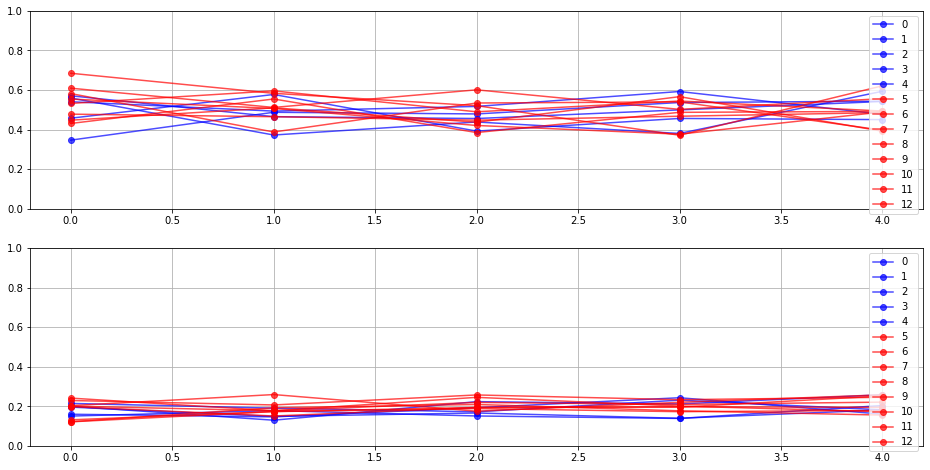

In [14]:
dim1_mean,dim1_std = get_dim_std(data_args,model_args,10,"syn.1.0",9)
dim2_mean,dim2_std = get_dim_std(data_args,model_args,10,"syn.1.1",9)
dim3_mean,dim3_std = get_dim_std(data_args,model_args,10,"syn.1.2",9)
dim4_mean,dim4_std = get_dim_std(data_args,model_args,10,"syn.1.3",9)
dim5_mean,dim5_std = get_dim_std(data_args,model_args,10,"syn.1.4",9)

dim_mean_timeline = np.stack([dim1_mean,dim2_mean,dim3_mean,dim4_mean,dim5_mean],axis=-1)
dim_std_timeline = np.stack([dim1_std,dim2_std,dim3_std,dim4_std,dim5_std],axis=-1)


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
fig,axes= plt.subplots(2,1)

for didx in range(dim_mean_timeline.shape[0]):
    color = "r" if didx>4 else "b"
    axes[0].plot(
                 dim_mean_timeline[didx,:],
                 "o-",
                 color=color,
                 label=didx,
                 alpha=0.7
    )
    
    axes[1].plot(
                dim_std_timeline[didx,:],
                "o-",
                 color=color,
                 label=didx,
                 alpha=0.7
    )
    

    axes[0].legend()
    axes[0].set_ylim(0.0,1.0)
    axes[0].grid()
    axes[1].legend()
    axes[1].set_ylim(0.0,1.0)
    axes[1].grid()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are in

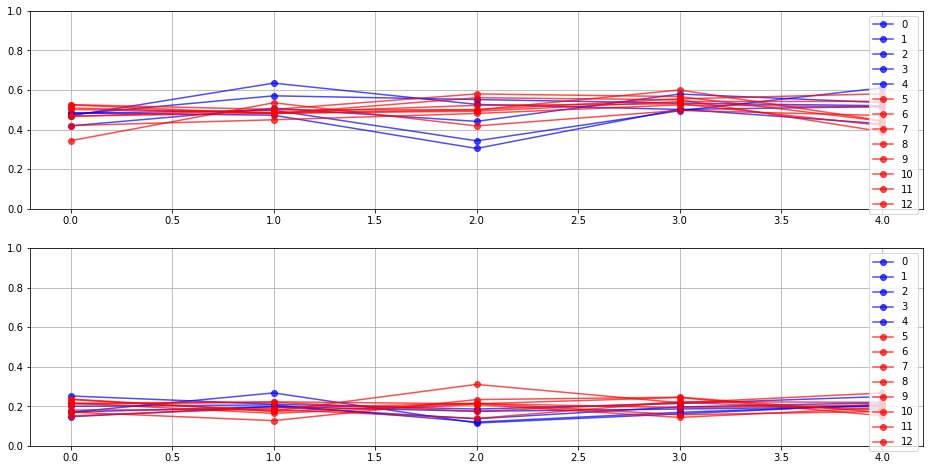

In [16]:
dim1_mean,dim1_std = get_dim_std(data_args,model_args,10,"syn.2.1",9)
dim2_mean,dim2_std = get_dim_std(data_args,model_args,10,"syn.2.2",9)
dim3_mean,dim3_std = get_dim_std(data_args,model_args,10,"syn.2.3",9)
dim4_mean,dim4_std = get_dim_std(data_args,model_args,10,"syn.2.4",9)
dim5_mean,dim5_std = get_dim_std(data_args,model_args,10,"syn.2.5",9)

dim_mean_timeline = np.stack([dim1_mean,dim2_mean,dim3_mean,dim4_mean,dim5_mean],axis=-1)
dim_std_timeline = np.stack([dim1_std,dim2_std,dim3_std,dim4_std,dim5_std],axis=-1)


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
fig,axes= plt.subplots(2,1)

for didx in range(dim_mean_timeline.shape[0]):
    color = "r" if didx>4 else "b"
    axes[0].plot(
                 dim_mean_timeline[didx,:],
                 "o-",
                 color=color,
                 label=didx,
                 alpha=0.7
    )
    
    axes[1].plot(
                dim_std_timeline[didx,:],
                "o-",
                 color=color,
                 label=didx,
                 alpha=0.7
    )
    

    axes[0].legend()
    axes[0].set_ylim(0.0,1.0)
    axes[0].grid()
    axes[1].legend()
    axes[1].set_ylim(0.0,1.0)
    axes[1].grid()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are in

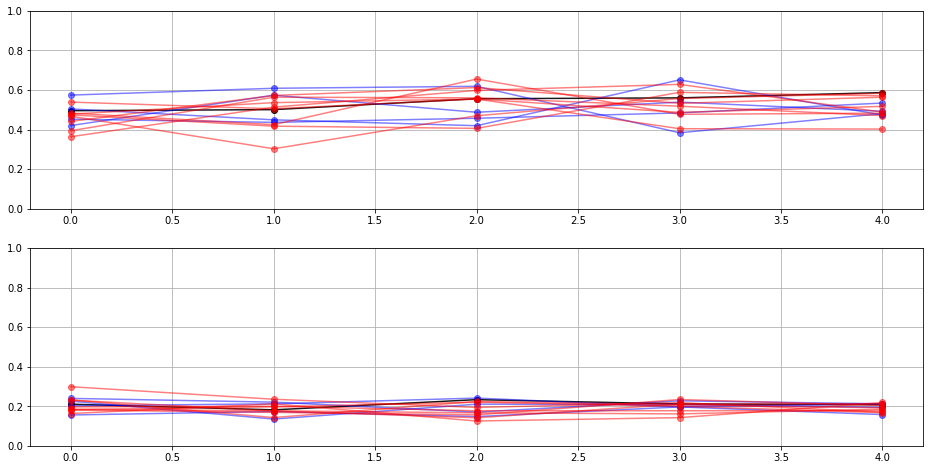

In [31]:
dim1_mean,dim1_std = get_dim_std(data_args,model_args,10,"syn.3.0",9)
dim2_mean,dim2_std = get_dim_std(data_args,model_args,10,"syn.3.1",9)
dim3_mean,dim3_std = get_dim_std(data_args,model_args,10,"syn.3.2",9)
dim4_mean,dim4_std = get_dim_std(data_args,model_args,10,"syn.3.3",9)
dim5_mean,dim5_std = get_dim_std(data_args,model_args,10,"syn.3.4",9)

dim_mean_timeline = np.stack([dim1_mean,dim2_mean,dim3_mean,dim4_mean,dim5_mean],axis=-1)
dim_std_timeline = np.stack([dim1_std,dim2_std,dim3_std,dim4_std,dim5_std],axis=-1)


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
fig,axes= plt.subplots(2,1)

for didx in range(dim_mean_timeline.shape[0]):
    color = "r" if didx>4 else "b"
    alpha=0.5
    if(didx==0):
        color="k"
        alpha=0.9
    axes[0].plot(
                 dim_mean_timeline[didx,:],
                 "o-",
                 color=color,
                 label=didx,
                 alpha=alpha
    )
    
    axes[1].plot(
                dim_std_timeline[didx,:],
                "o-",
                 color=color,
                 label=didx,
                 alpha=alpha
    )
    

#     axes[0].legend()
    axes[0].set_ylim(0.0,1.0)
    axes[0].grid()
#     axes[1].legend()
    axes[1].set_ylim(0.0,1.0)
    axes[1].grid()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are in

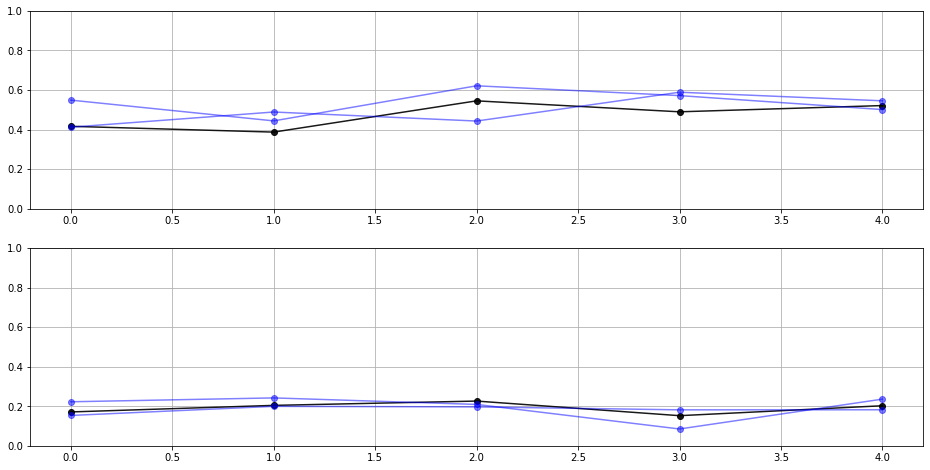

In [4]:
dim1_mean,dim1_std = get_dim_std(data_args,model_args,10,"syn.5.0",9)
dim2_mean,dim2_std = get_dim_std(data_args,model_args,10,"syn.5.1",9)
dim3_mean,dim3_std = get_dim_std(data_args,model_args,10,"syn.5.2",9)
dim4_mean,dim4_std = get_dim_std(data_args,model_args,10,"syn.5.3",9)
dim5_mean,dim5_std = get_dim_std(data_args,model_args,10,"syn.5.4",9)

dim_mean_timeline = np.stack([dim1_mean,dim2_mean,dim3_mean,dim4_mean,dim5_mean,],axis=-1)
dim_std_timeline = np.stack([dim1_std,dim2_std,dim3_std,dim4_std,dim5_std,],axis=-1)


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
fig,axes= plt.subplots(2,1)

for didx in range(dim_mean_timeline.shape[0]):
    color = "r" if didx>4 else "b"
    alpha=0.5
    if(didx==0):
        color="k"
        alpha=0.9
    axes[0].plot(
                 dim_mean_timeline[didx,:],
                 "o-",
                 color=color,
                 label=didx,
                 alpha=alpha
    )
    
    axes[1].plot(
                dim_std_timeline[didx,:],
                "o-",
                 color=color,
                 label=didx,
                 alpha=alpha
    )
    

#     axes[0].legend()
    axes[0].set_ylim(0.0,1.0)
    axes[0].grid()
#     axes[1].legend()
    axes[1].set_ylim(0.0,1.0)
    axes[1].grid()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are in

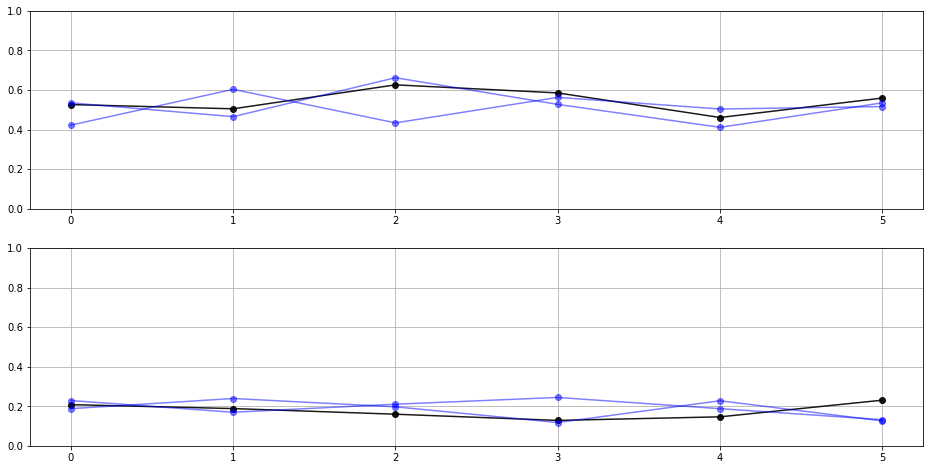

In [6]:
dim1_mean,dim1_std = get_dim_std(data_args,model_args,10,"syn.6.1",9)
dim2_mean,dim2_std = get_dim_std(data_args,model_args,10,"syn.6.2",9)
dim3_mean,dim3_std = get_dim_std(data_args,model_args,10,"syn.6.4",9)
dim4_mean,dim4_std = get_dim_std(data_args,model_args,10,"syn.6.5",9)
dim5_mean,dim5_std = get_dim_std(data_args,model_args,10,"syn.6.6",9)
dim6_mean,dim6_std = get_dim_std(data_args,model_args,10,"syn.6.3",9)

dim_mean_timeline = np.stack([dim1_mean,dim2_mean,dim3_mean,dim4_mean,dim5_mean,dim6_mean],axis=-1)
dim_std_timeline = np.stack([dim1_std,dim2_std,dim3_std,dim4_std,dim5_std,dim6_std],axis=-1)


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
fig,axes= plt.subplots(2,1)

for didx in range(dim_mean_timeline.shape[0]):
    color = "r" if didx>4 else "b"
    alpha=0.5
    if(didx==0):
        color="k"
        alpha=0.9
    axes[0].plot(
                 dim_mean_timeline[didx,:],
                 "o-",
                 color=color,
                 label=didx,
                 alpha=alpha
    )
    
    axes[1].plot(
                dim_std_timeline[didx,:],
                "o-",
                 color=color,
                 label=didx,
                 alpha=alpha
    )
    

#     axes[0].legend()
    axes[0].set_ylim(0.0,1.0)
    axes[0].grid()
#     axes[1].legend()
    axes[1].set_ylim(0.0,1.0)
    axes[1].grid()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are in

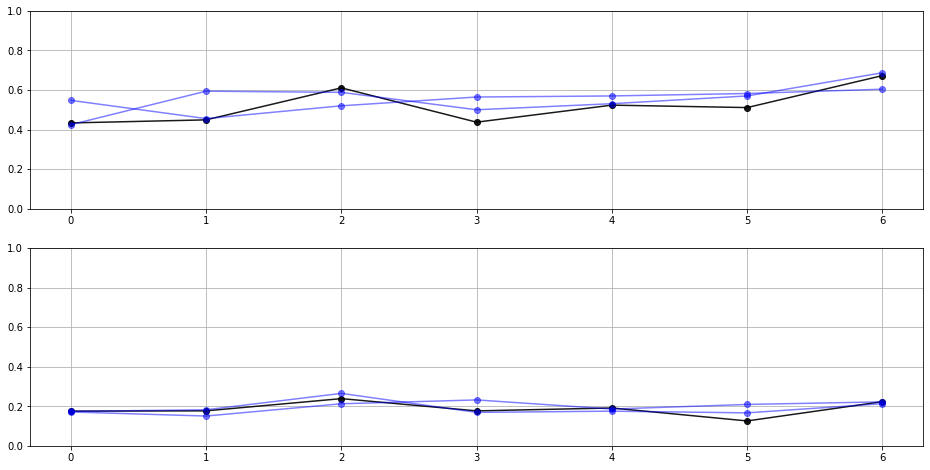

In [4]:

dim0_mean,dim0_std = get_dim_std(data_args,model_args,10,"syn.7.0",9)
dim1_mean,dim1_std = get_dim_std(data_args,model_args,10,"syn.7.1",9)
dim2_mean,dim2_std = get_dim_std(data_args,model_args,10,"syn.7.2",9)
dim3_mean,dim3_std = get_dim_std(data_args,model_args,10,"syn.7.3",9)
dim4_mean,dim4_std = get_dim_std(data_args,model_args,10,"syn.7.4",9)
dim5_mean,dim5_std = get_dim_std(data_args,model_args,10,"syn.7.5",9)
dim6_mean,dim6_std = get_dim_std(data_args,model_args,10,"syn.7.6",9)

dim_mean_timeline = np.stack([dim0_mean,dim1_mean,dim2_mean,dim3_mean,dim4_mean,dim5_mean,dim6_mean],axis=-1)
dim_std_timeline = np.stack([dim0_std,dim1_std,dim2_std,dim3_std,dim4_std,dim5_std,dim6_std],axis=-1)


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
fig,axes= plt.subplots(2,1)

for didx in range(dim_mean_timeline.shape[0]):
    color = "r" if didx>4 else "b"
    alpha=0.5
    if(didx==0):
        color="k"
        alpha=0.9
    axes[0].plot(
                 dim_mean_timeline[didx,:],
                 "o-",
                 color=color,
                 label=didx,
                 alpha=alpha
    )
    
    axes[1].plot(
                dim_std_timeline[didx,:],
                "o-",
                 color=color,
                 label=didx,
                 alpha=alpha
    )
    

#     axes[0].legend()
    axes[0].set_ylim(0.0,1.0)
    axes[0].grid()
#     axes[1].legend()
    axes[1].set_ylim(0.0,1.0)
    axes[1].grid()

In [8]:
dim6_mean,dim6_std, cat_weights = get_dim_std(data_args,model_args,10,"syn.7.6",9)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [15]:
cat_weights[4]

[]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are in

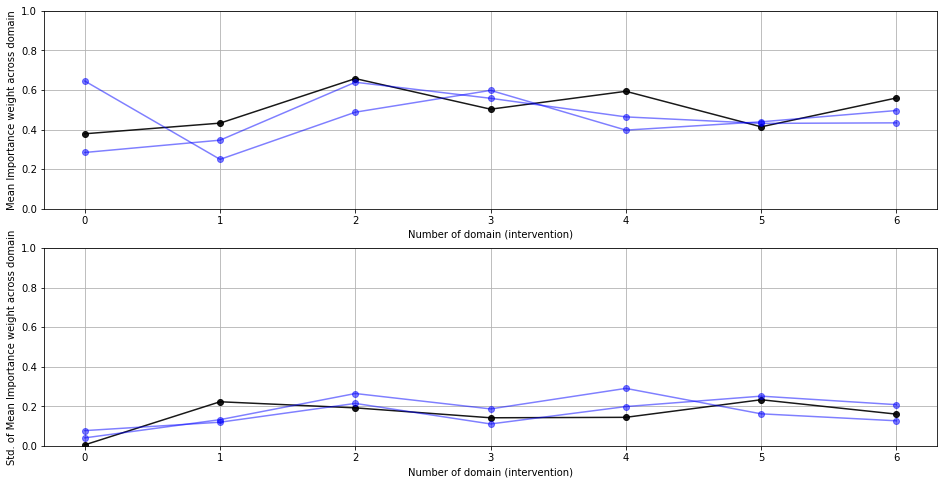

In [6]:

dim0_mean,dim0_std = get_dim_std(data_args,model_args,2,"syn.8.0",9)
dim1_mean,dim1_std = get_dim_std(data_args,model_args,3,"syn.8.1",9)
dim2_mean,dim2_std = get_dim_std(data_args,model_args,4,"syn.8.2",9)
dim3_mean,dim3_std = get_dim_std(data_args,model_args,5,"syn.8.3",9)
dim4_mean,dim4_std = get_dim_std(data_args,model_args,6,"syn.8.4",9)
dim5_mean,dim5_std = get_dim_std(data_args,model_args,7,"syn.8.5",9)
dim6_mean,dim6_std = get_dim_std(data_args,model_args,8,"syn.8.6",9)

dim_mean_timeline = np.stack([dim0_mean,dim1_mean,dim2_mean,dim3_mean,dim4_mean,dim5_mean,dim6_mean],axis=-1)
dim_std_timeline = np.stack([dim0_std,dim1_std,dim2_std,dim3_std,dim4_std,dim5_std,dim6_std],axis=-1)


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
fig,axes= plt.subplots(2,1)

for didx in range(dim_mean_timeline.shape[0]):
    color = "r" if didx>4 else "b"
    alpha=0.5
    if(didx==0):
        color="k"
        alpha=0.9
    axes[0].plot(
                 dim_mean_timeline[didx,:],
                 "o-",
                 color=color,
                 label=didx,
                 alpha=alpha
    )
    
    axes[1].plot(
                dim_std_timeline[didx,:],
                "o-",
                 color=color,
                 label=didx,
                 alpha=alpha
    )
    

#     axes[0].legend()
    axes[0].set_ylim(0.0,1.0)
    axes[0].grid()
#     axes[1].legend()
    axes[1].set_ylim(0.0,1.0)
    axes[1].grid()
    
    axes[0].set_xlabel("Number of domain (intervention)")
    axes[1].set_xlabel("Number of domain (intervention)")
    
    axes[0].set_ylabel("Mean Importance weight across domain")
    axes[1].set_ylabel("Std. of Mean Importance weight across domain")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are in

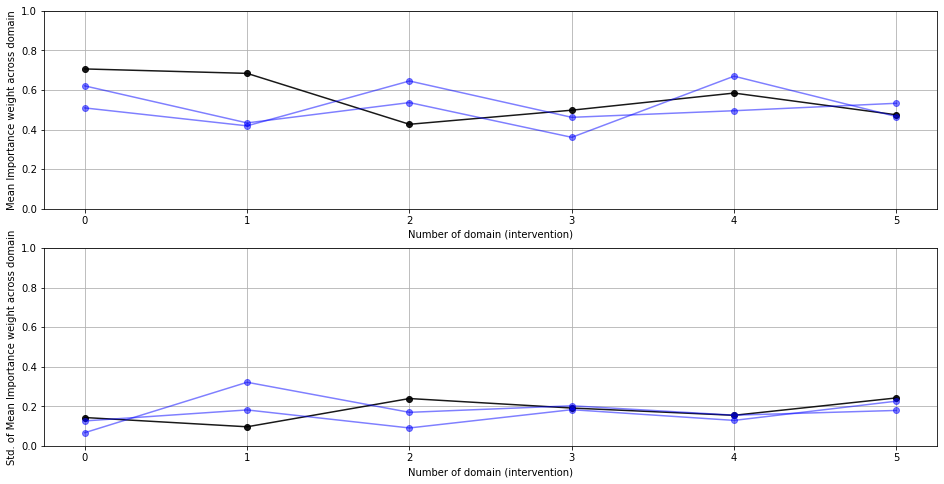

In [14]:

dim0_mean,dim0_std = get_dim_std(data_args,model_args,2,"syn.9.0",19)
dim1_mean,dim1_std = get_dim_std(data_args,model_args,3,"syn.9.1",19)
dim2_mean,dim2_std = get_dim_std(data_args,model_args,4,"syn.9.2",19)
dim3_mean,dim3_std = get_dim_std(data_args,model_args,5,"syn.9.3",19)
dim4_mean,dim4_std = get_dim_std(data_args,model_args,6,"syn.9.4",19)
dim5_mean,dim5_std = get_dim_std(data_args,model_args,7,"syn.9.5",19)
# dim6_mean,dim6_std = get_dim_std(data_args,model_args,8,"syn.8.6",19)

dim_mean_timeline = np.stack([dim0_mean,dim1_mean,dim2_mean,dim3_mean,dim4_mean,dim5_mean],axis=-1)
dim_std_timeline = np.stack([dim0_std,dim1_std,dim2_std,dim3_std,dim4_std,dim5_std],axis=-1)


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
fig,axes= plt.subplots(2,1)

for didx in range(dim_mean_timeline.shape[0]):
    color = "r" if didx>4 else "b"
    alpha=0.5
    if(didx==0):
        color="k"
        alpha=0.9
    axes[0].plot(
                 dim_mean_timeline[didx,:],
                 "o-",
                 color=color,
                 label=didx,
                 alpha=alpha
    )
    
    axes[1].plot(
                dim_std_timeline[didx,:],
                "o-",
                 color=color,
                 label=didx,
                 alpha=alpha
    )
    

#     axes[0].legend()
    axes[0].set_ylim(0.0,1.0)
    axes[0].grid()
#     axes[1].legend()
    axes[1].set_ylim(0.0,1.0)
    axes[1].grid()
    
    axes[0].set_xlabel("Number of domain (intervention)")
    axes[1].set_xlabel("Number of domain (intervention)")
    
    axes[0].set_ylabel("Mean Importance weight across domain")
    axes[1].set_ylabel("Std. of Mean Importance weight across domain")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are in

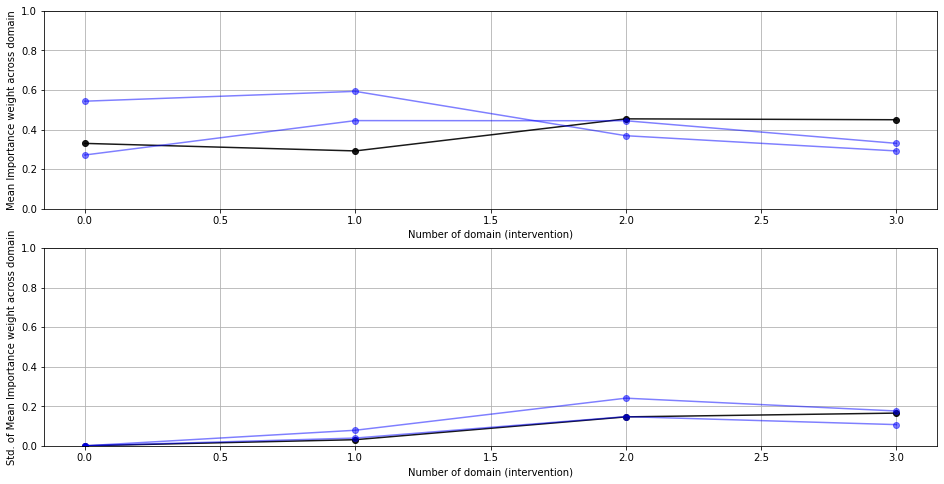

In [7]:

dim0_mean,dim0_std = get_dim_std(data_args,model_args,1,"syn.12.0",9)
dim1_mean,dim1_std = get_dim_std(data_args,model_args,2,"syn.12.1",9)
dim2_mean,dim2_std = get_dim_std(data_args,model_args,3,"syn.12.2",9)
dim3_mean,dim3_std = get_dim_std(data_args,model_args,4,"syn.12.3",9)
# dim4_mean,dim4_std = get_dim_std(data_args,model_args,6,"syn.9.4",19)
# dim5_mean,dim5_std = get_dim_std(data_args,model_args,7,"syn.9.5",19)
# dim6_mean,dim6_std = get_dim_std(data_args,model_args,8,"syn.8.6",19)

dim_mean_timeline = np.stack([dim0_mean,dim1_mean,dim2_mean,dim3_mean,],axis=-1)
dim_std_timeline = np.stack([dim0_std,dim1_std,dim2_std,dim3_std,],axis=-1)


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
fig,axes= plt.subplots(2,1)

for didx in range(dim_mean_timeline.shape[0]):
    color = "r" if didx>4 else "b"
    alpha=0.5
    if(didx==0):
        color="k"
        alpha=0.9
    axes[0].plot(
                 dim_mean_timeline[didx,:],
                 "o-",
                 color=color,
                 label=didx,
                 alpha=alpha
    )
    
    axes[1].plot(
                dim_std_timeline[didx,:],
                "o-",
                 color=color,
                 label=didx,
                 alpha=alpha
    )
    

#     axes[0].legend()
    axes[0].set_ylim(0.0,1.0)
    axes[0].grid()
#     axes[1].legend()
    axes[1].set_ylim(0.0,1.0)
    axes[1].grid()
    
    axes[0].set_xlabel("Number of domain (intervention)")
    axes[1].set_xlabel("Number of domain (intervention)")
    
    axes[0].set_ylabel("Mean Importance weight across domain")
    axes[1].set_ylabel("Std. of Mean Importance weight across domain")

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are in

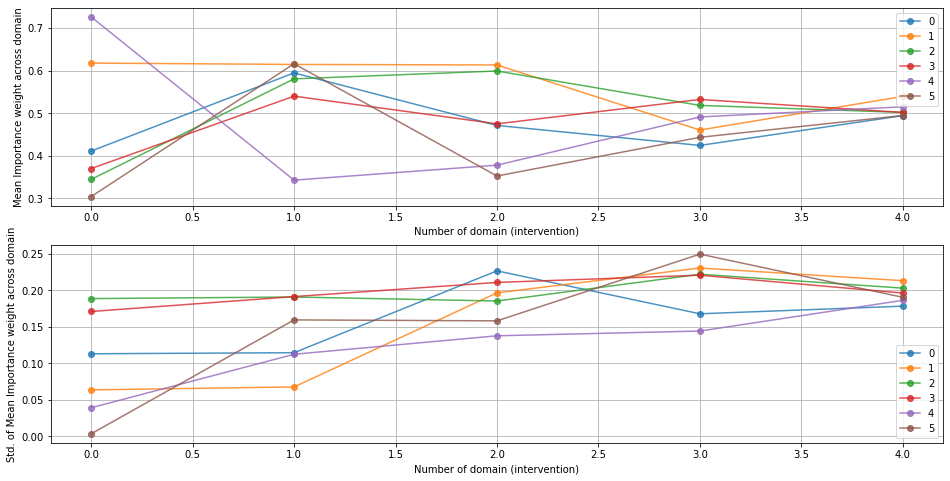

In [11]:

dim0_mean,dim0_std = get_dim_std(data_args,model_args,2,"syn.10.0",9)
dim1_mean,dim1_std = get_dim_std(data_args,model_args,4,"syn.10.1",9)
dim2_mean,dim2_std = get_dim_std(data_args,model_args,8,"syn.10.2",9)
dim3_mean,dim3_std = get_dim_std(data_args,model_args,16,"syn.10.3",9)
dim4_mean,dim4_std = get_dim_std(data_args,model_args,32,"syn.10.4",9)
# dim5_mean,dim5_std = get_dim_std(data_args,model_args,7,"syn.9.5",9)
# dim6_mean,dim6_std = get_dim_std(data_args,model_args,8,"syn.8.6",9)

dim_mean_timeline = np.stack([dim0_mean,dim1_mean,dim2_mean,dim3_mean,dim4_mean],axis=-1)
dim_std_timeline = np.stack([dim0_std,dim1_std,dim2_std,dim3_std,dim4_std],axis=-1)


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
fig,axes= plt.subplots(2,1)

for didx in range(dim_mean_timeline.shape[0]):
#     color = "b"
    alpha=0.8
#     if(didx==0):
#         color="k"
#         alpha=0.9
    axes[0].plot(
                 dim_mean_timeline[didx,:],
                 "o-",
#                  color=color,
                 label=didx,
                 alpha=alpha
    )
    
    axes[1].plot(
                dim_std_timeline[didx,:],
                "o-",
#                  color=color,
                 label=didx,
                 alpha=alpha
    )
    

    axes[0].legend()
#     axes[0].set_ylim(0.0,1.0)
    axes[0].grid(b=True)
    axes[1].legend()
#     axes[1].set_ylim(0.0,1.0)
    axes[1].grid(b=True)
    
    axes[0].set_xlabel("Number of domain (intervention)")
    axes[1].set_xlabel("Number of domain (intervention)")
    
    axes[0].set_ylabel("Mean Importance weight across domain")
    axes[1].set_ylabel("Std. of Mean Importance weight across domain")

Intervention location selected for the topics:
array([(2, 3, 5, 7)], dtype=object)
Flipping the labels of: 500 many variable
num_0:1024	num_1:976
Flipping the labels of: 500 many variable
num_0:1018	num_1:982


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


cat:0	celoss:0.05910	vacc:0.97356
cat:1	celoss:0.05910	vacc:0.93269
Intervention location selected for the topics:
array([(2, 3, 5, 7), (1, 2, 4, 5, 7, 8), (2, 3, 4, 5)], dtype=object)
Flipping the labels of: 500 many variable
num_0:1024	num_1:976
Flipping the labels of: 500 many variable
num_0:984	num_1:1016
Flipping the labels of: 500 many variable
num_0:1026	num_1:974
Flipping the labels of: 500 many variable
num_0:978	num_1:1022


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


cat:0	celoss:0.05875	vacc:0.97115
cat:1	celoss:0.05875	vacc:0.96635
cat:2	celoss:0.05875	vacc:0.95913
cat:3	celoss:0.05875	vacc:0.95192
Intervention location selected for the topics:
array([(2, 3, 5, 7), (1, 2, 4, 5, 7, 8), (2, 3, 4, 5), (1, 3, 5, 7, 8),
       (4, 7), (1, 4, 7), (1, 2, 7, 8)], dtype=object)
Flipping the labels of: 500 many variable
num_0:1024	num_1:976
Flipping the labels of: 500 many variable
num_0:984	num_1:1016
Flipping the labels of: 500 many variable
num_0:1026	num_1:974
Flipping the labels of: 500 many variable
num_0:986	num_1:1014
Flipping the labels of: 500 many variable
num_0:992	num_1:1008
Flipping the labels of: 500 many variable
num_0:990	num_1:1010
Flipping the labels of: 500 many variable
num_0:998	num_1:1002
Flipping the labels of: 500 many variable
num_0:1002	num_1:998


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


cat:0	celoss:0.06284	vacc:0.96875
cat:1	celoss:0.06284	vacc:0.94952
cat:2	celoss:0.06284	vacc:0.96394
cat:3	celoss:0.06284	vacc:0.96875
cat:4	celoss:0.06284	vacc:0.94231
cat:5	celoss:0.06284	vacc:0.96154
cat:6	celoss:0.06284	vacc:0.95913
cat:7	celoss:0.06284	vacc:0.95192
Intervention location selected for the topics:
array([(2, 3, 5, 7), (1, 2, 4, 5, 7, 8), (2, 3, 4, 5), (1, 3, 5, 7, 8),
       (4, 7), (1, 4, 7), (1, 2, 7, 8), (1, 3, 4), (2, 5, 6),
       (2, 3, 6, 7, 8), (2, 3, 5, 6), (1, 3, 7), (1, 2, 3, 7, 8),
       (1, 2, 3, 4, 7, 8), (2, 4, 5, 6)], dtype=object)
Flipping the labels of: 500 many variable
num_0:1024	num_1:976
Flipping the labels of: 500 many variable
num_0:984	num_1:1016
Flipping the labels of: 500 many variable
num_0:1026	num_1:974
Flipping the labels of: 500 many variable
num_0:986	num_1:1014
Flipping the labels of: 500 many variable
num_0:992	num_1:1008
Flipping the labels of: 500 many variable
num_0:990	num_1:1010
Flipping the labels of: 500 many variable
num_0

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


cat:0	celoss:0.05462	vacc:0.96154
cat:1	celoss:0.05462	vacc:0.96394
cat:2	celoss:0.05462	vacc:0.94712
cat:3	celoss:0.05462	vacc:0.96635
cat:4	celoss:0.05462	vacc:0.95673
cat:5	celoss:0.05462	vacc:0.96154
cat:6	celoss:0.05462	vacc:0.94712
cat:7	celoss:0.05462	vacc:0.95913
cat:8	celoss:0.05462	vacc:0.95673
cat:9	celoss:0.05462	vacc:0.96154
cat:10	celoss:0.05462	vacc:0.94712
cat:11	celoss:0.05462	vacc:0.97115
cat:12	celoss:0.05462	vacc:0.96394
cat:13	celoss:0.05462	vacc:0.97115
cat:14	celoss:0.05462	vacc:0.96154
cat:15	celoss:0.05462	vacc:0.96875
Intervention location selected for the topics:
array([(2, 3, 5, 7), (1, 2, 4, 5, 7, 8), (2, 3, 4, 5), (1, 3, 5, 7, 8),
       (4, 7), (1, 4, 7), (1, 2, 7, 8), (1, 3, 4), (2, 5, 6),
       (2, 3, 6, 7, 8), (2, 3, 5, 6), (1, 3, 7), (1, 2, 3, 7, 8),
       (1, 2, 3, 4, 7, 8), (2, 4, 5, 6), (1, 5), (2, 3, 5, 6, 7), (5, 7),
       (4, 6, 7, 8), (3, 5, 6), (7,), (3, 6, 8), (3, 8), (1, 3, 6, 7, 8),
       (5, 6, 8), (2, 3, 4, 5, 6, 7), (1, 3, 4, 6, 7), 

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


cat:0	celoss:0.05457	vacc:0.96154
cat:1	celoss:0.05457	vacc:0.94471
cat:2	celoss:0.05457	vacc:0.96394
cat:3	celoss:0.05457	vacc:0.96875
cat:4	celoss:0.05457	vacc:0.94712
cat:5	celoss:0.05457	vacc:0.95673
cat:6	celoss:0.05457	vacc:0.95192
cat:7	celoss:0.05457	vacc:0.95192
cat:8	celoss:0.05457	vacc:0.96154
cat:9	celoss:0.05457	vacc:0.95433
cat:10	celoss:0.05457	vacc:0.95913
cat:11	celoss:0.05457	vacc:0.97115
cat:12	celoss:0.05457	vacc:0.97837
cat:13	celoss:0.05457	vacc:0.96394
cat:14	celoss:0.05457	vacc:0.96635
cat:15	celoss:0.05457	vacc:0.96394
cat:16	celoss:0.05457	vacc:0.96154
cat:17	celoss:0.05457	vacc:0.96394
cat:18	celoss:0.05457	vacc:0.93510
cat:19	celoss:0.05457	vacc:0.96635
cat:20	celoss:0.05457	vacc:0.97596
cat:21	celoss:0.05457	vacc:0.93990
cat:22	celoss:0.05457	vacc:0.96635
cat:23	celoss:0.05457	vacc:0.98317
cat:24	celoss:0.05457	vacc:0.96635
cat:25	celoss:0.05457	vacc:0.94471
cat:26	celoss:0.05457	vacc:0.96635
cat:27	celoss:0.05457	vacc:0.96635
cat:28	celoss:0.05457	vacc:0.9

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


cat:0	celoss:0.05066	vacc:0.97115
cat:1	celoss:0.05066	vacc:0.94952
cat:2	celoss:0.05066	vacc:0.97356
cat:3	celoss:0.05066	vacc:0.96635
cat:4	celoss:0.05066	vacc:0.94231
cat:5	celoss:0.05066	vacc:0.95192
cat:6	celoss:0.05066	vacc:0.95192
cat:7	celoss:0.05066	vacc:0.95913
cat:8	celoss:0.05066	vacc:0.95673
cat:9	celoss:0.05066	vacc:0.96635
cat:10	celoss:0.05066	vacc:0.95433
cat:11	celoss:0.05066	vacc:0.96875
cat:12	celoss:0.05066	vacc:0.96394
cat:13	celoss:0.05066	vacc:0.96635
cat:14	celoss:0.05066	vacc:0.96875
cat:15	celoss:0.05066	vacc:0.94712
cat:16	celoss:0.05066	vacc:0.96875
cat:17	celoss:0.05066	vacc:0.95673
cat:18	celoss:0.05066	vacc:0.95433
cat:19	celoss:0.05066	vacc:0.97356
cat:20	celoss:0.05066	vacc:0.97596
cat:21	celoss:0.05066	vacc:0.95913
cat:22	celoss:0.05066	vacc:0.97115
cat:23	celoss:0.05066	vacc:0.97837
cat:24	celoss:0.05066	vacc:0.96394
cat:25	celoss:0.05066	vacc:0.95192
cat:26	celoss:0.05066	vacc:0.95433
cat:27	celoss:0.05066	vacc:0.95192
cat:28	celoss:0.05066	vacc:0.9

Flipping the labels of: 500 many variable
num_0:1010	num_1:990
Flipping the labels of: 500 many variable
num_0:966	num_1:1034
Flipping the labels of: 500 many variable
num_0:974	num_1:1026
Flipping the labels of: 500 many variable
num_0:994	num_1:1006
Flipping the labels of: 500 many variable
num_0:1032	num_1:968
Flipping the labels of: 500 many variable
num_0:968	num_1:1032
Flipping the labels of: 500 many variable
num_0:1002	num_1:998
Flipping the labels of: 500 many variable
num_0:1000	num_1:1000
Flipping the labels of: 500 many variable
num_0:1038	num_1:962
Flipping the labels of: 500 many variable
num_0:1028	num_1:972
Flipping the labels of: 500 many variable
num_0:1024	num_1:976
Flipping the labels of: 500 many variable
num_0:1030	num_1:970
Flipping the labels of: 500 many variable
num_0:988	num_1:1012
Flipping the labels of: 500 many variable
num_0:996	num_1:1004
Flipping the labels of: 500 many variable
num_0:980	num_1:1020
Flipping the labels of: 500 many variable
num_0:1008	n

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


cat:0	celoss:0.05101	vacc:0.97115
cat:1	celoss:0.05101	vacc:0.97115
cat:2	celoss:0.05101	vacc:0.95433
cat:3	celoss:0.05101	vacc:0.97356
cat:4	celoss:0.05101	vacc:0.93990
cat:5	celoss:0.05101	vacc:0.96394
cat:6	celoss:0.05101	vacc:0.95192
cat:7	celoss:0.05101	vacc:0.94712
cat:8	celoss:0.05101	vacc:0.95673
cat:9	celoss:0.05101	vacc:0.95192
cat:10	celoss:0.05101	vacc:0.96154
cat:11	celoss:0.05101	vacc:0.97356
cat:12	celoss:0.05101	vacc:0.97596
cat:13	celoss:0.05101	vacc:0.97596
cat:14	celoss:0.05101	vacc:0.98317
cat:15	celoss:0.05101	vacc:0.97596
cat:16	celoss:0.05101	vacc:0.96154
cat:17	celoss:0.05101	vacc:0.96635
cat:18	celoss:0.05101	vacc:0.95192
cat:19	celoss:0.05101	vacc:0.93990
cat:20	celoss:0.05101	vacc:0.96635
cat:21	celoss:0.05101	vacc:0.96154
cat:22	celoss:0.05101	vacc:0.96635
cat:23	celoss:0.05101	vacc:0.98077
cat:24	celoss:0.05101	vacc:0.95673
cat:25	celoss:0.05101	vacc:0.94952
cat:26	celoss:0.05101	vacc:0.95673
cat:27	celoss:0.05101	vacc:0.95433
cat:28	celoss:0.05101	vacc:0.9

Flipping the labels of: 500 many variable
num_0:970	num_1:1030
Flipping the labels of: 500 many variable
num_0:996	num_1:1004
Flipping the labels of: 500 many variable
num_0:1012	num_1:988
Flipping the labels of: 500 many variable
num_0:996	num_1:1004
Flipping the labels of: 500 many variable
num_0:978	num_1:1022
Flipping the labels of: 500 many variable
num_0:1014	num_1:986
Flipping the labels of: 500 many variable
num_0:1020	num_1:980
Flipping the labels of: 500 many variable
num_0:1046	num_1:954
Flipping the labels of: 500 many variable
num_0:1000	num_1:1000
Flipping the labels of: 500 many variable
num_0:1006	num_1:994
Flipping the labels of: 500 many variable
num_0:1012	num_1:988
Flipping the labels of: 500 many variable
num_0:1022	num_1:978
Flipping the labels of: 500 many variable
num_0:1004	num_1:996
Flipping the labels of: 500 many variable
num_0:990	num_1:1010
Flipping the labels of: 500 many variable
num_0:986	num_1:1014
Flipping the labels of: 500 many variable
num_0:978	nu

Flipping the labels of: 500 many variable
num_0:1002	num_1:998
Flipping the labels of: 500 many variable
num_0:976	num_1:1024
Flipping the labels of: 500 many variable
num_0:990	num_1:1010
Flipping the labels of: 500 many variable
num_0:990	num_1:1010
Flipping the labels of: 500 many variable
num_0:1002	num_1:998
Flipping the labels of: 500 many variable
num_0:994	num_1:1006
Flipping the labels of: 500 many variable
num_0:976	num_1:1024
Flipping the labels of: 500 many variable
num_0:1006	num_1:994
Flipping the labels of: 500 many variable
num_0:990	num_1:1010
Flipping the labels of: 500 many variable
num_0:988	num_1:1012
Flipping the labels of: 500 many variable
num_0:1006	num_1:994
Flipping the labels of: 500 many variable
num_0:966	num_1:1034
Flipping the labels of: 500 many variable
num_0:1026	num_1:974
Flipping the labels of: 500 many variable
num_0:1028	num_1:972
Flipping the labels of: 500 many variable
num_0:984	num_1:1016
Flipping the labels of: 500 many variable
num_0:974	num

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


cat:0	celoss:0.05109	vacc:0.97115
cat:1	celoss:0.05109	vacc:0.95913
cat:2	celoss:0.05109	vacc:0.95913
cat:3	celoss:0.05109	vacc:0.96154
cat:4	celoss:0.05109	vacc:0.93750
cat:5	celoss:0.05109	vacc:0.96394
cat:6	celoss:0.05109	vacc:0.95433
cat:7	celoss:0.05109	vacc:0.95433
cat:8	celoss:0.05109	vacc:0.95673
cat:9	celoss:0.05109	vacc:0.96635
cat:10	celoss:0.05109	vacc:0.95192
cat:11	celoss:0.05109	vacc:0.97356
cat:12	celoss:0.05109	vacc:0.97115
cat:13	celoss:0.05109	vacc:0.96635
cat:14	celoss:0.05109	vacc:0.95913
cat:15	celoss:0.05109	vacc:0.97115
cat:16	celoss:0.05109	vacc:0.97596
cat:17	celoss:0.05109	vacc:0.95433
cat:18	celoss:0.05109	vacc:0.95673
cat:19	celoss:0.05109	vacc:0.94712
cat:20	celoss:0.05109	vacc:0.97356
cat:21	celoss:0.05109	vacc:0.96875
cat:22	celoss:0.05109	vacc:0.96635
cat:23	celoss:0.05109	vacc:0.97596
cat:24	celoss:0.05109	vacc:0.97356
cat:25	celoss:0.05109	vacc:0.95192
cat:26	celoss:0.05109	vacc:0.96394
cat:27	celoss:0.05109	vacc:0.95673
cat:28	celoss:0.05109	vacc:0.9

cat:235	celoss:0.05109	vacc:0.95913
cat:236	celoss:0.05109	vacc:0.97837
cat:237	celoss:0.05109	vacc:0.95433
cat:238	celoss:0.05109	vacc:0.96394
cat:239	celoss:0.05109	vacc:0.97356
cat:240	celoss:0.05109	vacc:0.96394
cat:241	celoss:0.05109	vacc:0.96394
cat:242	celoss:0.05109	vacc:0.97596
cat:243	celoss:0.05109	vacc:0.96875
cat:244	celoss:0.05109	vacc:0.96875
cat:245	celoss:0.05109	vacc:0.93510
cat:246	celoss:0.05109	vacc:0.96394
cat:247	celoss:0.05109	vacc:0.96635
cat:248	celoss:0.05109	vacc:0.93750
cat:249	celoss:0.05109	vacc:0.95673
cat:250	celoss:0.05109	vacc:0.97356
cat:251	celoss:0.05109	vacc:0.96154
cat:252	celoss:0.05109	vacc:0.97115
cat:253	celoss:0.05109	vacc:0.96875
cat:254	celoss:0.05109	vacc:0.97115
cat:255	celoss:0.05109	vacc:0.94712


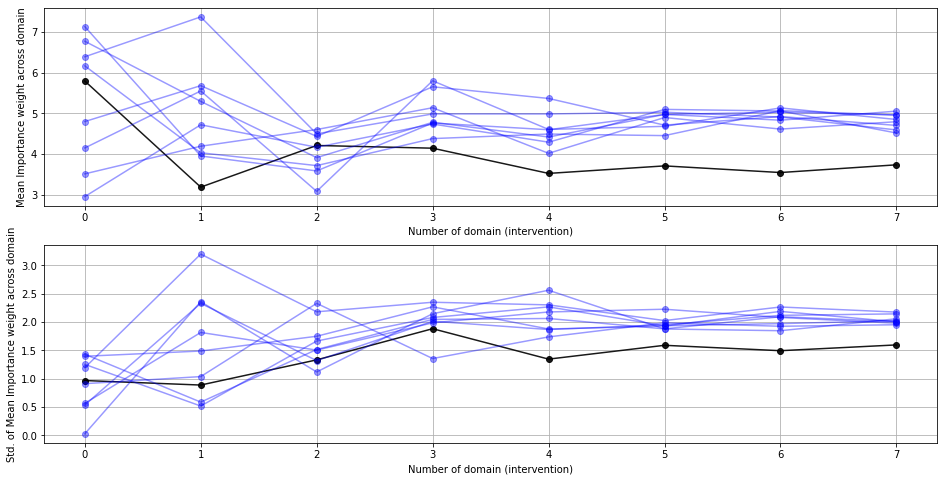

In [31]:

dim0_mean,dim0_std = get_dim_std(data_args,model_args,2,"syn.11.0",9)
dim1_mean,dim1_std = get_dim_std(data_args,model_args,4,"syn.11.1",9)
dim2_mean,dim2_std = get_dim_std(data_args,model_args,8,"syn.11.2",9)
dim3_mean,dim3_std = get_dim_std(data_args,model_args,16,"syn.11.3",9)
dim4_mean,dim4_std = get_dim_std(data_args,model_args,32,"syn.11.4",9)
dim5_mean,dim5_std = get_dim_std(data_args,model_args,64,"syn.11.5",9)
dim6_mean,dim6_std = get_dim_std(data_args,model_args,128,"syn.11.6",9)
dim7_mean,dim7_std = get_dim_std(data_args,model_args,256,"syn.11.7",9)

dim_mean_timeline = np.stack([dim0_mean,dim1_mean,dim2_mean,dim3_mean,dim4_mean,dim5_mean,dim6_mean,dim7_mean],axis=-1)
dim_std_timeline = np.stack([dim0_std,dim1_std,dim2_std,dim3_std,dim4_std,dim5_std,dim6_std,dim7_std],axis=-1)


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
fig,axes= plt.subplots(2,1)

for didx in range(dim_mean_timeline.shape[0]):
    color = "b"
    alpha=0.4
    if(didx==0):
        color="k"
        alpha=0.9
    axes[0].plot(
                 dim_mean_timeline[didx,:],
                 "o-",
                 color=color,
                 label=didx,
                 alpha=alpha
    )
    
    axes[1].plot(
                dim_std_timeline[didx,:],
                "o-",
                 color=color,
                 label=didx,
                 alpha=alpha
    )
    

#     axes[0].legend()
#     axes[0].set_ylim(0.0,1.0)
    axes[0].grid(b=True)
#     axes[1].legend()
#     axes[1].set_ylim(0.0,1.0)
    axes[1].grid(b=True)
    
    axes[0].set_xlabel("Number of domain (intervention)")
    axes[1].set_xlabel("Number of domain (intervention)")
    
    axes[0].set_ylabel("Mean Importance weight across domain")
    axes[1].set_ylabel("Std. of Mean Importance weight across domain")

/home/t-abkumar/debugging/nlp_data_handle.py:1013: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  interv_loc_list = np.random.choice(all_interv_loc,replace=False,size=num_cat-1)


Intervention location selected for the topics:
array([], dtype=object)
Flipping the labels of: 500 many variable
num_0:972	num_1:1028


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


cat:0	celoss:0.63115	vacc:0.69712
Intervention location selected for the topics:
array([(2, 3, 4, 5), (1, 2, 3)], dtype=object)
Flipping the labels of: 500 many variable
num_0:1008	num_1:992
Flipping the labels of: 500 many variable
num_0:1014	num_1:986
Flipping the labels of: 500 many variable
num_0:1022	num_1:978


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


cat:0	celoss:0.60839	vacc:0.69471
cat:1	celoss:0.60839	vacc:0.67308
cat:2	celoss:0.60839	vacc:0.72115
Intervention location selected for the topics:
array([(2, 3, 4, 5), (1, 2, 3), (2, 3, 5), (), (2, 4, 5), (1, 2, 4, 5)],
      dtype=object)
Flipping the labels of: 500 many variable
num_0:1008	num_1:992
Flipping the labels of: 500 many variable
num_0:1014	num_1:986
Flipping the labels of: 500 many variable
num_0:1024	num_1:976
Flipping the labels of: 500 many variable
num_0:1010	num_1:990
Flipping the labels of: 500 many variable
num_0:968	num_1:1032
Flipping the labels of: 500 many variable
num_0:976	num_1:1024
Flipping the labels of: 500 many variable
num_0:1006	num_1:994


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


cat:0	celoss:0.59603	vacc:0.70913
cat:1	celoss:0.59603	vacc:0.66346
cat:2	celoss:0.59603	vacc:0.73798
cat:3	celoss:0.59603	vacc:0.70673
cat:4	celoss:0.59603	vacc:0.73077
cat:5	celoss:0.59603	vacc:0.73317
cat:6	celoss:0.59603	vacc:0.69471
Intervention location selected for the topics:
array([(2, 3, 4, 5), (1, 2, 3), (2, 3, 5), (), (2, 4, 5), (1, 2, 4, 5),
       (3,), (1, 2, 3, 4, 5), (1,), (1, 3, 4, 5), (2, 5), (3, 4), (4,),
       (2, 4)], dtype=object)
Flipping the labels of: 500 many variable
num_0:1008	num_1:992
Flipping the labels of: 500 many variable
num_0:1014	num_1:986
Flipping the labels of: 500 many variable
num_0:1024	num_1:976
Flipping the labels of: 500 many variable
num_0:1010	num_1:990
Flipping the labels of: 500 many variable
num_0:968	num_1:1032
Flipping the labels of: 500 many variable
num_0:976	num_1:1024
Flipping the labels of: 500 many variable
num_0:988	num_1:1012
Flipping the labels of: 500 many variable
num_0:1014	num_1:986
Flipping the labels of: 500 many vari

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


cat:0	celoss:0.58767	vacc:0.70673
cat:1	celoss:0.58767	vacc:0.69712
cat:2	celoss:0.58767	vacc:0.73798
cat:3	celoss:0.58767	vacc:0.70192
cat:4	celoss:0.58767	vacc:0.72115
cat:5	celoss:0.58767	vacc:0.71635
cat:6	celoss:0.58767	vacc:0.70433
cat:7	celoss:0.58767	vacc:0.67788
cat:8	celoss:0.58767	vacc:0.74519
cat:9	celoss:0.58767	vacc:0.71875
cat:10	celoss:0.58767	vacc:0.72837
cat:11	celoss:0.58767	vacc:0.69952
cat:12	celoss:0.58767	vacc:0.73798
cat:13	celoss:0.58767	vacc:0.74038
cat:14	celoss:0.58767	vacc:0.69712
Intervention location selected for the topics:
array([(2, 3, 4, 5), (1, 2, 3), (2, 3, 5), (), (2, 4, 5), (1, 2, 4, 5),
       (3,), (1, 2, 3, 4, 5), (1,), (1, 3, 4, 5), (2, 5), (3, 4), (4,),
       (2, 4), (1, 5), (3, 4, 5), (2, 3), (3, 5), (1, 4, 5), (1, 3),
       (1, 2, 3, 4), (2, 3, 4), (1, 3, 4), (1, 2), (1, 2, 4), (1, 2, 5),
       (2,), (1, 3, 5), (1, 2, 3, 5), (4, 5)], dtype=object)
Flipping the labels of: 500 many variable
num_0:1008	num_1:992
Flipping the labels of: 500 

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


cat:0	celoss:0.58443	vacc:0.71635
cat:1	celoss:0.58443	vacc:0.68510
cat:2	celoss:0.58443	vacc:0.71394
cat:3	celoss:0.58443	vacc:0.69471
cat:4	celoss:0.58443	vacc:0.72356
cat:5	celoss:0.58443	vacc:0.73798
cat:6	celoss:0.58443	vacc:0.71635
cat:7	celoss:0.58443	vacc:0.67067
cat:8	celoss:0.58443	vacc:0.73317
cat:9	celoss:0.58443	vacc:0.71394
cat:10	celoss:0.58443	vacc:0.71875
cat:11	celoss:0.58443	vacc:0.69952
cat:12	celoss:0.58443	vacc:0.72115
cat:13	celoss:0.58443	vacc:0.75000
cat:14	celoss:0.58443	vacc:0.71154
cat:15	celoss:0.58443	vacc:0.72115
cat:16	celoss:0.58443	vacc:0.72596
cat:17	celoss:0.58443	vacc:0.70433
cat:18	celoss:0.58443	vacc:0.72115
cat:19	celoss:0.58443	vacc:0.70433
cat:20	celoss:0.58443	vacc:0.67308
cat:21	celoss:0.58443	vacc:0.71635
cat:22	celoss:0.58443	vacc:0.73558
cat:23	celoss:0.58443	vacc:0.72596
cat:24	celoss:0.58443	vacc:0.71394
cat:25	celoss:0.58443	vacc:0.70433
cat:26	celoss:0.58443	vacc:0.70673
cat:27	celoss:0.58443	vacc:0.70192
cat:28	celoss:0.58443	vacc:0.7

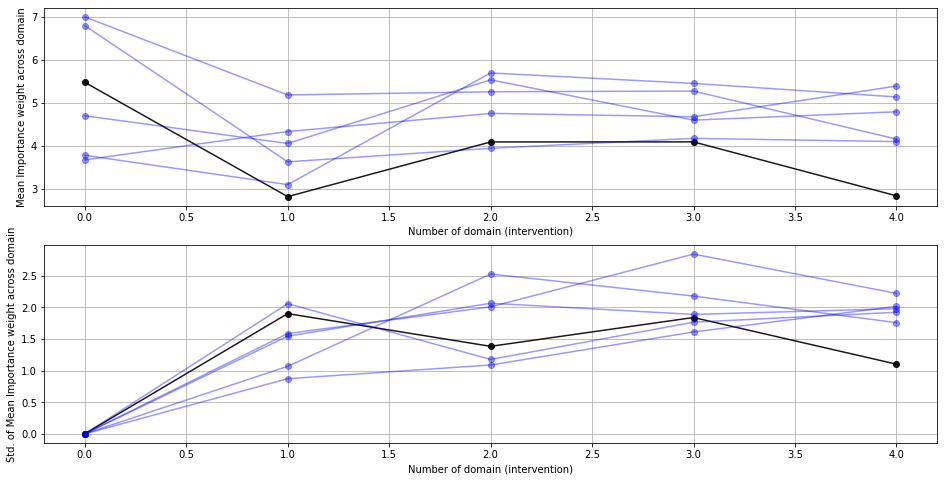

In [26]:

dim0_mean,dim0_std = get_dim_std(data_args,model_args,2-1,"syn.13.0",9)
dim1_mean,dim1_std = get_dim_std(data_args,model_args,4-1,"syn.13.1",9)
dim2_mean,dim2_std = get_dim_std(data_args,model_args,8-1,"syn.13.2",9)
dim3_mean,dim3_std = get_dim_std(data_args,model_args,16-1,"syn.13.3",9)
dim4_mean,dim4_std = get_dim_std(data_args,model_args,32-1,"syn.13.4",9)

dim_mean_timeline = np.stack([dim0_mean,dim1_mean,dim2_mean,dim3_mean,dim4_mean,],axis=-1)
dim_std_timeline = np.stack([dim0_std,dim1_std,dim2_std,dim3_std,dim4_std,],axis=-1)


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
fig,axes= plt.subplots(2,1)

for didx in range(dim_mean_timeline.shape[0]):
    color = "b"
    alpha=0.4
    if(didx==0):
        color="k"
        alpha=0.9
    axes[0].plot(
                 dim_mean_timeline[didx,:],
                 "o-",
                 color=color,
                 label=didx,
                 alpha=alpha
    )
    
    axes[1].plot(
                dim_std_timeline[didx,:],
                "o-",
                 color=color,
                 label=didx,
                 alpha=alpha
    )
    

#     axes[0].legend()
#     axes[0].set_ylim(0.0,1.0)
    axes[0].grid(b=True)
#     axes[1].legend()
#     axes[1].set_ylim(0.0,1.0)
    axes[1].grid(b=True)
    
    axes[0].set_xlabel("Number of domain (intervention)")
    axes[1].set_xlabel("Number of domain (intervention)")
    
    axes[0].set_ylabel("Mean Importance weight across domain")
    axes[1].set_ylabel("Std. of Mean Importance weight across domain")

/home/t-abkumar/debugging/nlp_data_handle.py:1014: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  interv_loc_list = np.random.choice(all_interv_loc,replace=False,size=num_cat-1)


Intervention location selected for the topics:
array([], dtype=object)
Flipping the labels of: 500 many variable
num_0:982	num_1:1018


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


cat:0	celoss:0.59748	vacc:0.75481
Intervention location selected for the topics:
array([(2, 3)], dtype=object)
Flipping the labels of: 500 many variable
num_0:1008	num_1:992
Flipping the labels of: 500 many variable
num_0:1008	num_1:992


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


cat:0	celoss:0.58355	vacc:0.75721
cat:1	celoss:0.58355	vacc:0.73798
Intervention location selected for the topics:
array([(2, 3), (3,)], dtype=object)
Flipping the labels of: 500 many variable
num_0:1008	num_1:992
Flipping the labels of: 500 many variable
num_0:996	num_1:1004
Flipping the labels of: 500 many variable
num_0:992	num_1:1008


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


cat:0	celoss:0.58319	vacc:0.75721
cat:1	celoss:0.58319	vacc:0.73558
cat:2	celoss:0.58319	vacc:0.69231
Intervention location selected for the topics:
array([(2, 3), (3,), (1, 2, 3)], dtype=object)
Flipping the labels of: 500 many variable
num_0:1008	num_1:992
Flipping the labels of: 500 many variable
num_0:996	num_1:1004
Flipping the labels of: 500 many variable
num_0:968	num_1:1032
Flipping the labels of: 500 many variable
num_0:998	num_1:1002


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


cat:0	celoss:0.58541	vacc:0.75721
cat:1	celoss:0.58541	vacc:0.72356
cat:2	celoss:0.58541	vacc:0.71154
cat:3	celoss:0.58541	vacc:0.66346
Intervention location selected for the topics:
array([(2, 3), (3,), (1, 2, 3), (1,)], dtype=object)
Flipping the labels of: 500 many variable
num_0:1008	num_1:992
Flipping the labels of: 500 many variable
num_0:996	num_1:1004
Flipping the labels of: 500 many variable
num_0:968	num_1:1032
Flipping the labels of: 500 many variable
num_0:1028	num_1:972
Flipping the labels of: 500 many variable
num_0:1024	num_1:976


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


cat:0	celoss:0.59742	vacc:0.75721
cat:1	celoss:0.59742	vacc:0.73558
cat:2	celoss:0.59742	vacc:0.70673
cat:3	celoss:0.59742	vacc:0.67067
cat:4	celoss:0.59742	vacc:0.62500


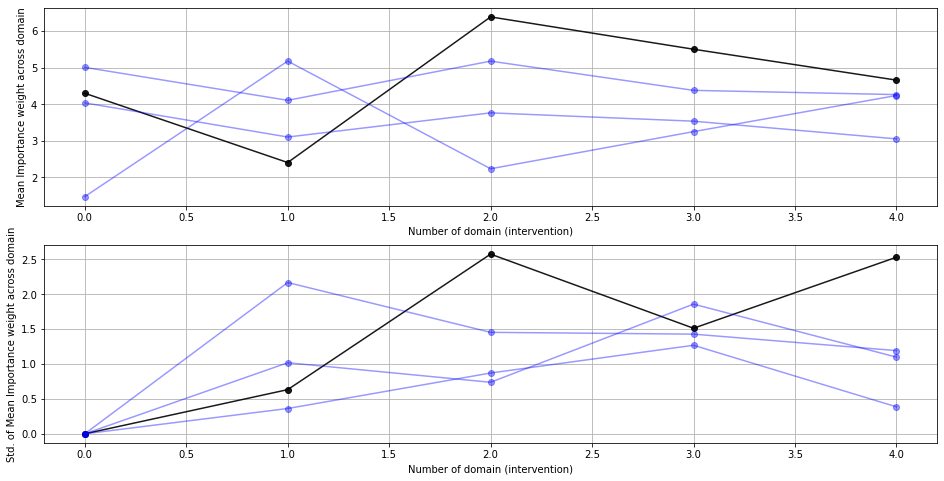

In [8]:

dim0_mean,dim0_std = get_dim_std(data_args,model_args,2-1,"syn.14.0",9)
dim1_mean,dim1_std = get_dim_std(data_args,model_args,3-1,"syn.14.1",9)
dim2_mean,dim2_std = get_dim_std(data_args,model_args,4-1,"syn.14.2",9)
dim3_mean,dim3_std = get_dim_std(data_args,model_args,5-1,"syn.14.3",9)
dim4_mean,dim4_std = get_dim_std(data_args,model_args,6-1,"syn.14.4",9)

dim_mean_timeline = np.stack([dim0_mean,dim1_mean,dim2_mean,dim3_mean,dim4_mean,],axis=-1)
dim_std_timeline = np.stack([dim0_std,dim1_std,dim2_std,dim3_std,dim4_std,],axis=-1)


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
fig,axes= plt.subplots(2,1)

for didx in range(dim_mean_timeline.shape[0]):
    color = "b"
    alpha=0.4
    if(didx==0):
        color="k"
        alpha=0.9
    axes[0].plot(
                 dim_mean_timeline[didx,:],
                 "o-",
                 color=color,
                 label=didx,
                 alpha=alpha
    )
    
    axes[1].plot(
                dim_std_timeline[didx,:],
                "o-",
                 color=color,
                 label=didx,
                 alpha=alpha
    )
    

#     axes[0].legend()
#     axes[0].set_ylim(0.0,1.0)
    axes[0].grid(b=True)
#     axes[1].legend()
#     axes[1].set_ylim(0.0,1.0)
    axes[1].grid(b=True)
    
    axes[0].set_xlabel("Number of domain (intervention)")
    axes[1].set_xlabel("Number of domain (intervention)")
    
    axes[0].set_ylabel("Mean Importance weight across domain")
    axes[1].set_ylabel("Std. of Mean Importance weight across domain")

Flipping the labels of: 500 many variable
num_0:1010	num_1:990


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


cat:0	celoss:0.59323	vacc:0.76442
Flipping the labels of: 500 many variable
num_0:1010	num_1:990
Flipping the labels of: 500 many variable
num_0:992	num_1:1008


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


cat:0	celoss:0.57317	vacc:0.76683
cat:1	celoss:0.57317	vacc:0.74279
Flipping the labels of: 500 many variable
num_0:1010	num_1:990
Flipping the labels of: 500 many variable
num_0:992	num_1:1008
Flipping the labels of: 500 many variable
num_0:1000	num_1:1000


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


cat:0	celoss:0.56715	vacc:0.76683
cat:1	celoss:0.56715	vacc:0.74038
cat:2	celoss:0.56715	vacc:0.69471
Flipping the labels of: 500 many variable
num_0:1010	num_1:990
Flipping the labels of: 500 many variable
num_0:992	num_1:1008
Flipping the labels of: 500 many variable
num_0:1000	num_1:1000
Flipping the labels of: 500 many variable
num_0:982	num_1:1018


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


cat:0	celoss:0.56893	vacc:0.76923
cat:1	celoss:0.56893	vacc:0.75240
cat:2	celoss:0.56893	vacc:0.70433
cat:3	celoss:0.56893	vacc:0.68990
Flipping the labels of: 500 many variable
num_0:1010	num_1:990
Flipping the labels of: 500 many variable
num_0:992	num_1:1008
Flipping the labels of: 500 many variable
num_0:1000	num_1:1000
Flipping the labels of: 500 many variable
num_0:982	num_1:1018
Flipping the labels of: 500 many variable
num_0:980	num_1:1020


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


cat:0	celoss:0.57706	vacc:0.76683
cat:1	celoss:0.57706	vacc:0.73798
cat:2	celoss:0.57706	vacc:0.71154
cat:3	celoss:0.57706	vacc:0.67788
cat:4	celoss:0.57706	vacc:0.67788


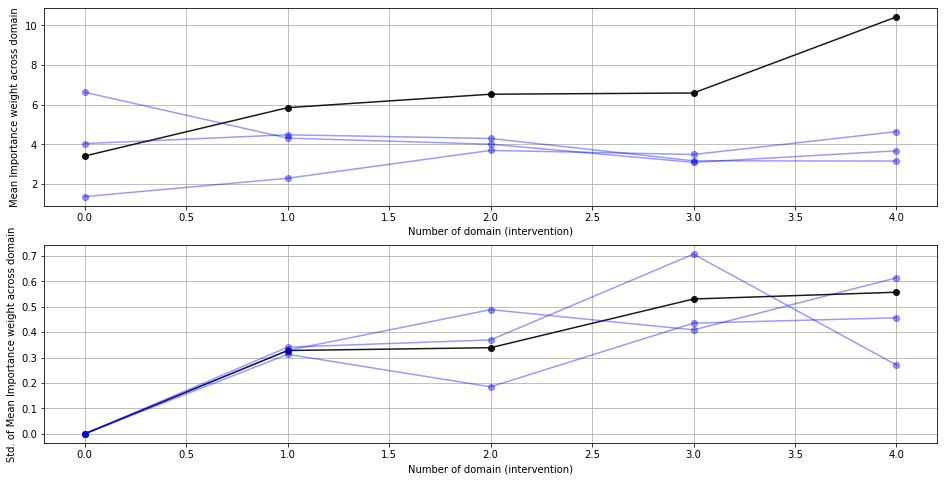

In [6]:

dim0_mean,dim0_std = get_dim_std(data_args,model_args,2-1,"syn.15.0",19)
dim1_mean,dim1_std = get_dim_std(data_args,model_args,3-1,"syn.15.1",19)
dim2_mean,dim2_std = get_dim_std(data_args,model_args,4-1,"syn.15.2",19)
dim3_mean,dim3_std = get_dim_std(data_args,model_args,5-1,"syn.15.3",19)
dim4_mean,dim4_std = get_dim_std(data_args,model_args,6-1,"syn.15.4",19)

dim_mean_timeline = np.stack([dim0_mean,dim1_mean,dim2_mean,dim3_mean,dim4_mean,],axis=-1)
dim_std_timeline = np.stack([dim0_std,dim1_std,dim2_std,dim3_std,dim4_std,],axis=-1)


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
fig,axes= plt.subplots(2,1)

for didx in range(dim_mean_timeline.shape[0]):
    color = "b"
    alpha=0.4
    if(didx==0):
        color="k"
        alpha=0.9
    axes[0].plot(
                 dim_mean_timeline[didx,:],
                 "o-",
                 color=color,
                 label=didx,
                 alpha=alpha
    )
    
    axes[1].plot(
                dim_std_timeline[didx,:],
                "o-",
                 color=color,
                 label=didx,
                 alpha=alpha
    )
    

#     axes[0].legend()
#     axes[0].set_ylim(0.0,1.0)
    axes[0].grid(b=True)
#     axes[1].legend()
#     axes[1].set_ylim(0.0,1.0)
    axes[1].grid(b=True)
    
    axes[0].set_xlabel("Number of domain (intervention)")
    axes[1].set_xlabel("Number of domain (intervention)")
    
    axes[0].set_ylabel("Mean Importance weight across domain")
    axes[1].set_ylabel("Std. of Mean Importance weight across domain")

In [28]:

dim0_mean,dim0_std,dim0_weights = get_dim_std(data_args,model_args,3,"syn.16.0",29)
dim1_mean,dim1_std,dim1_weights = get_dim_std(data_args,model_args,5,"syn.16.1",29)
dim2_mean,dim2_std,dim2_weights = get_dim_std(data_args,model_args,7,"syn.16.2",29)
dim3_mean,dim3_std,dim3_weights = get_dim_std(data_args,model_args,9,"syn.16.3",29)
dim4_mean,dim4_std,dim4_weights = get_dim_std(data_args,model_args,11,"syn.16.4",29)

dim_mean_timeline = np.stack([dim0_mean,dim1_mean,dim2_mean,dim3_mean,dim4_mean,],axis=-1)
dim_std_timeline = np.stack([dim0_std,dim1_std,dim2_std,dim3_std,dim4_std,],axis=-1)




Flipping the labels of: 500 many variable
num_0:1010	num_1:990
Flipping the labels of: 500 many variable
num_0:992	num_1:1008
Flipping the labels of: 500 many variable
num_0:1000	num_1:1000


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


cat:0	celoss:0.42573	vacc:0.90144
cat:1	celoss:0.42573	vacc:0.74038
cat:2	celoss:0.42573	vacc:0.87260
Flipping the labels of: 500 many variable
num_0:1010	num_1:990
Flipping the labels of: 500 many variable
num_0:992	num_1:1008
Flipping the labels of: 500 many variable
num_0:1000	num_1:1000
Flipping the labels of: 500 many variable
num_0:982	num_1:1018
Flipping the labels of: 500 many variable
num_0:980	num_1:1020


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


cat:0	celoss:0.43131	vacc:0.90144
cat:1	celoss:0.43131	vacc:0.73798
cat:2	celoss:0.43131	vacc:0.85577
cat:3	celoss:0.43131	vacc:0.68990
cat:4	celoss:0.43131	vacc:0.83413
Flipping the labels of: 500 many variable
num_0:1010	num_1:990
Flipping the labels of: 500 many variable
num_0:992	num_1:1008
Flipping the labels of: 500 many variable
num_0:1000	num_1:1000
Flipping the labels of: 500 many variable
num_0:982	num_1:1018
Flipping the labels of: 500 many variable
num_0:980	num_1:1020
Flipping the labels of: 500 many variable
num_0:1022	num_1:978
Flipping the labels of: 500 many variable
num_0:1034	num_1:966


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


cat:0	celoss:0.45739	vacc:0.90385
cat:1	celoss:0.45739	vacc:0.73798
cat:2	celoss:0.45739	vacc:0.85817
cat:3	celoss:0.45739	vacc:0.67548
cat:4	celoss:0.45739	vacc:0.81731
cat:5	celoss:0.45739	vacc:0.68510
cat:6	celoss:0.45739	vacc:0.86058
Flipping the labels of: 500 many variable
num_0:1010	num_1:990
Flipping the labels of: 500 many variable
num_0:992	num_1:1008
Flipping the labels of: 500 many variable
num_0:1000	num_1:1000
Flipping the labels of: 500 many variable
num_0:982	num_1:1018
Flipping the labels of: 500 many variable
num_0:980	num_1:1020
Flipping the labels of: 500 many variable
num_0:1022	num_1:978
Flipping the labels of: 500 many variable
num_0:1034	num_1:966
Flipping the labels of: 500 many variable
num_0:982	num_1:1018
Flipping the labels of: 500 many variable
num_0:988	num_1:1012


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


cat:0	celoss:0.47201	vacc:0.90144
cat:1	celoss:0.47201	vacc:0.74519
cat:2	celoss:0.47201	vacc:0.85817
cat:3	celoss:0.47201	vacc:0.67308
cat:4	celoss:0.47201	vacc:0.80288
cat:5	celoss:0.47201	vacc:0.66827
cat:6	celoss:0.47201	vacc:0.84135
cat:7	celoss:0.47201	vacc:0.62260
cat:8	celoss:0.47201	vacc:0.89423
Flipping the labels of: 500 many variable
num_0:1010	num_1:990
Flipping the labels of: 500 many variable
num_0:992	num_1:1008
Flipping the labels of: 500 many variable
num_0:1000	num_1:1000
Flipping the labels of: 500 many variable
num_0:982	num_1:1018
Flipping the labels of: 500 many variable
num_0:980	num_1:1020
Flipping the labels of: 500 many variable
num_0:1022	num_1:978
Flipping the labels of: 500 many variable
num_0:1034	num_1:966
Flipping the labels of: 500 many variable
num_0:982	num_1:1018
Flipping the labels of: 500 many variable
num_0:988	num_1:1012
Flipping the labels of: 500 many variable
num_0:1008	num_1:992
Flipping the labels of: 500 many variable
num_0:998	num_1:1002


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


cat:0	celoss:0.50170	vacc:0.90385
cat:1	celoss:0.50170	vacc:0.75240
cat:2	celoss:0.50170	vacc:0.85577
cat:3	celoss:0.50170	vacc:0.68269
cat:4	celoss:0.50170	vacc:0.81731
cat:5	celoss:0.50170	vacc:0.65625
cat:6	celoss:0.50170	vacc:0.83173
cat:7	celoss:0.50170	vacc:0.62981
cat:8	celoss:0.50170	vacc:0.80529
cat:9	celoss:0.50170	vacc:0.57212
cat:10	celoss:0.50170	vacc:0.85817


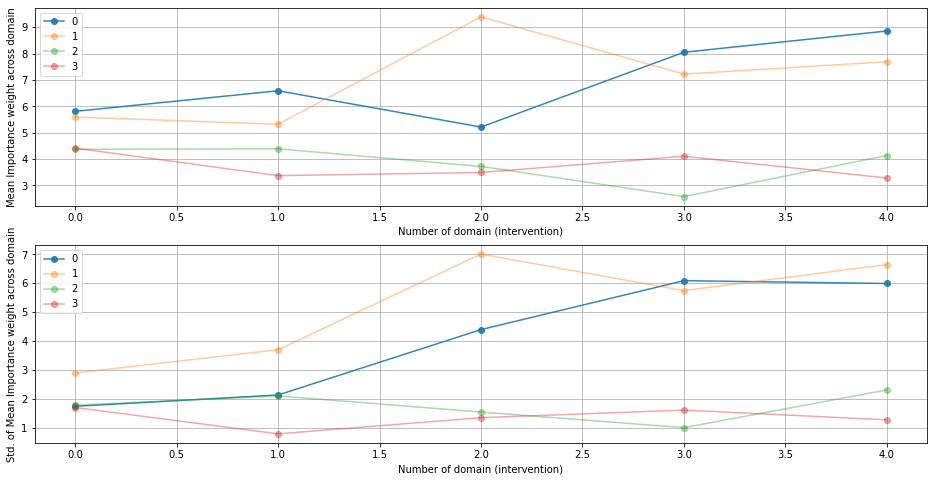

In [29]:
plot_my_timeline(dim_mean_timeline,dim_std_timeline)

In [30]:
dim0_weights

array([[3.58729  , 7.846898 , 5.9786954],
       [9.425757 , 2.4373288, 4.9023166],
       [1.841083 , 5.653826 , 5.592398 ],
       [2.0377421, 5.247238 , 5.942718 ]], dtype=float32)

In [31]:
dim1_weights

array([[ 6.626469 ,  4.592015 , 10.4365425,  6.6723824,  4.598357 ],
       [ 4.753412 ,  2.0590272, 12.490127 ,  3.2263007,  4.053702 ],
       [ 6.3536625,  1.1789218,  3.5827856,  7.0157757,  3.7767086],
       [ 3.758718 ,  4.0795255,  3.8847256,  3.19755  ,  1.8912714]],
      dtype=float32)

In [32]:
dim4_weights

array([[ 2.525431  ,  8.444616  ,  6.543614  ,  4.24303   ,  6.2045956 ,
        20.145481  , 10.916139  , 10.928057  ,  1.3128476 , 19.854242  ,
         6.2852416 ],
       [ 6.6046147 ,  2.195541  ,  7.7670636 ,  4.9231205 , 12.338203  ,
         3.4726858 , 18.291286  ,  0.88231426, 21.953562  ,  4.0174766 ,
         2.1180477 ],
       [ 6.965731  ,  8.165483  ,  5.3185534 ,  1.0618862 ,  2.6439254 ,
         1.6921588 ,  1.4238769 ,  3.9444723 ,  5.724568  ,  5.877158  ,
         2.5814862 ],
       [ 1.5607731 ,  3.896161  ,  5.4501376 ,  2.8950865 ,  1.8379114 ,
         3.9231844 ,  3.2041843 ,  1.2514424 ,  3.0649335 ,  4.794642  ,
         4.1245723 ]], dtype=float32)

([<matplotlib.axis.XTick at 0x7f5d94660c10>,
 [Text(0, 0, '0'),
  Text(0, 1, '0'),
  Text(1, 0, '1'),
  Text(1, 1, '1'),
  Text(2, 0, '2'),
  Text(2, 1, '2'),
  Text(3, 0, '3'),
  Text(3, 1, '3'),
  Text(4, 0, '4'),
  Text(4, 1, '4'),
  Text(5, 0, '5'),
  Text(5, 1, '5'),
  Text(6, 0, '6'),
  Text(6, 1, '6'),
  Text(7, 0, '7'),
  Text(7, 1, '7'),
  Text(8, 0, '8'),
  Text(8, 1, '8'),
  Text(9, 0, '9'),
  Text(9, 1, '9'),
  Text(10, 0, '10'),
  Text(10, 1, '10')])

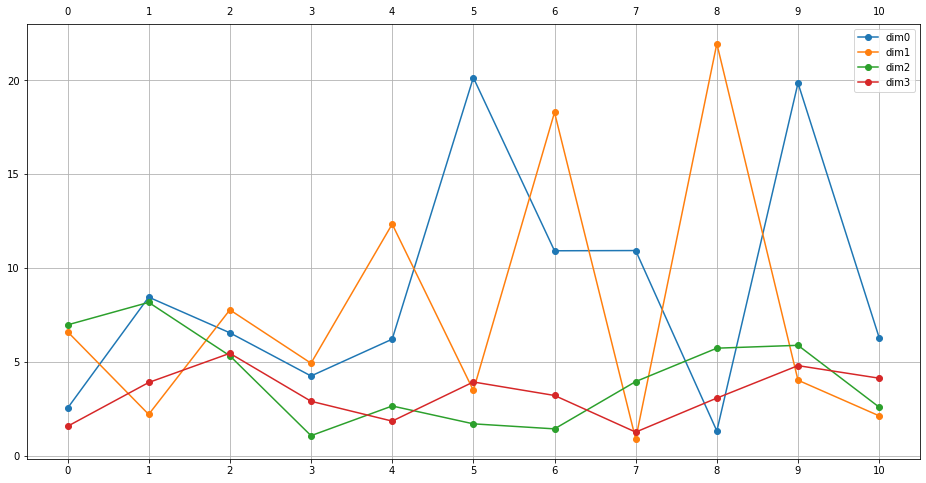

In [44]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
# fig,axes= plt.subplots(2,1)
dim_p_weights = dim4_weights
for didx in range(dim_p_weights.shape[0]):
    plt.plot(range(dim_p_weights.shape[1]),dim_p_weights[didx,:],"o-",label="dim{}".format(didx))

plt.legend()
plt.grid(b=True)
plt.xticks(range(dim_p_weights.shape[1]),range(dim_p_weights.shape[1]),visible=True)


In [3]:
def get_subset_valid_timeline(data_args,model_args,num_cat,expt_name,load_weight_epoch):
    #Updating the category number
    data_args["cat_list"]=list(range(num_cat))
    
    #Getting the dataset for validation and loading the weight
    data_handler = DataHandleTransformer(data_args)
    all_cat_ds = data_handler.create_synthetic_dataset2()
    data_args["cat_list"]=data_handler.data_args["cat_list"]
    
    #Creating the classifier
    classifier = TransformerClassifier(data_args,model_args)
    classifier.compile(
        keras.optimizers.Adam(learning_rate=model_args["lr"])
    )
    #Loading the checkpoint
    checkpoint_path = "nlp_logs/{}/cp_{}.ckpt".format(expt_name,load_weight_epoch)
    checkpoint_dir = os.path.dirname(checkpoint_path)
    classifier.load_weights(checkpoint_path)
    
    #Get the gate tensor
    gate_tensor = get_dimension_gate(data_args,model_args)
    
    #Now running one trip of validation
    from collections import defaultdict
    all_subset_vacc_timeline = defaultdict(list)
    for cidx,(cat,cat_ds) in enumerate(all_cat_ds.items()):
        #Evaluating the classifier and loading the weights
#         for data_batch in cat_ds:
#             classifier.valid_step(cidx,data_batch,gate_tensor)
#             break

        #Now we will print the metric for this category
        print("cat:{}\tceloss:{:0.5f}\tvacc:{:0.5f}".format(
                                        cat,
                                        classifier.sent_pred_xentropy.result(),
                                        classifier.sent_valid_acc_list[cidx].result(),
                )
        )
        #Tracking the timeline for each of subset
        #Since the classifier are in order of thier spuriousness level we need not worry
        all_subset_vacc_timeline[cat[1]].append(classifier.sent_valid_acc_list[cidx].result())
    
    #Now plotting the timeline for each of the subset
    import matplotlib.pyplot as plt
    plt.rcParams['figure.figsize'] = [16, 8]
#     fig,axes= plt.subplots(2,1)
    
    for sub,sub_timeline in all_subset_vacc_timeline.items():
        plt.plot(sub_timeline,"o-",label="{}".format(sub))
    
    plt.legend()
    plt.grid()
    plt.xlabel("domains (different degree of spuriousness)")
    plt.ylabel("validation accuracy (in-domain)")
    

Flipping the labels of: 500 many variable
num_0:1002	num_1:998
Flipping the labels of: 500 many variable
num_0:974	num_1:1026
Flipping the labels of: 500 many variable
num_0:986	num_1:1014
Flipping the labels of: 500 many variable
num_0:1046	num_1:954


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


cat:(0.2, ())	celoss:0.49444	vacc:0.50372
cat:(0.2, (0,))	celoss:0.49444	vacc:0.73201
cat:(0.2, (1,))	celoss:0.49444	vacc:0.78660
cat:(0.2, (2,))	celoss:0.49444	vacc:0.62779
cat:(0.2, (0, 1))	celoss:0.49444	vacc:0.78660
cat:(0.2, (0, 2))	celoss:0.49444	vacc:0.72953
cat:(0.2, (1, 2))	celoss:0.49444	vacc:0.78412
cat:(0.2, (0, 1, 2))	celoss:0.49444	vacc:0.78164
cat:(0.4, ())	celoss:0.49444	vacc:0.51365
cat:(0.4, (0,))	celoss:0.49444	vacc:0.79404
cat:(0.4, (1,))	celoss:0.49444	vacc:0.88834
cat:(0.4, (2,))	celoss:0.49444	vacc:0.66998
cat:(0.4, (0, 1))	celoss:0.49444	vacc:0.88586
cat:(0.4, (0, 2))	celoss:0.49444	vacc:0.79653
cat:(0.4, (1, 2))	celoss:0.49444	vacc:0.88089
cat:(0.4, (0, 1, 2))	celoss:0.49444	vacc:0.89082
cat:(0.6000000000000001, ())	celoss:0.49444	vacc:0.51861
cat:(0.6000000000000001, (0,))	celoss:0.49444	vacc:0.76427
cat:(0.6000000000000001, (1,))	celoss:0.49444	vacc:0.91315
cat:(0.6000000000000001, (2,))	celoss:0.49444	vacc:0.61787
cat:(0.6000000000000001, (0, 1))	celoss:0.49

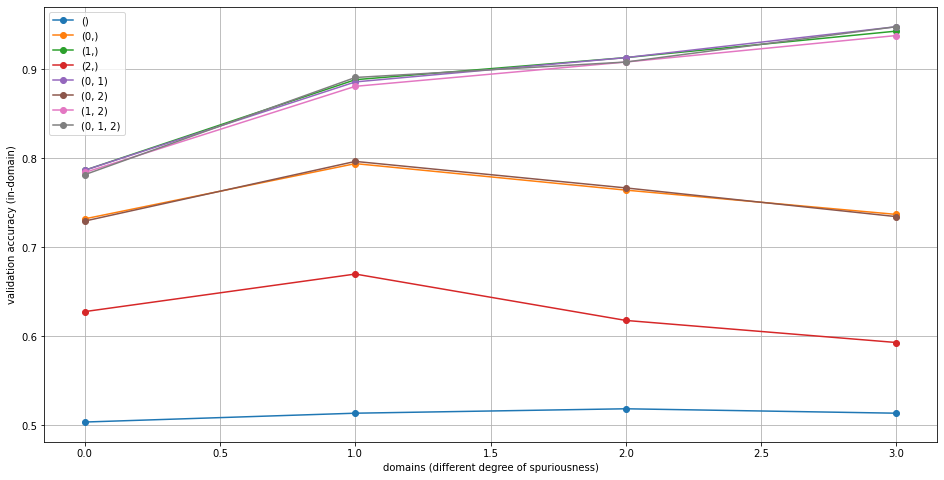

In [4]:
get_subset_valid_timeline(data_args,model_args,4,"syn.17.0",9)

Flipping the labels of: 500 many variable
num_0:1002	num_1:998
Flipping the labels of: 500 many variable
num_0:974	num_1:1026
Flipping the labels of: 500 many variable
num_0:986	num_1:1014
Flipping the labels of: 500 many variable
num_0:1046	num_1:954
Flipping the labels of: 500 many variable
num_0:1006	num_1:994
Flipping the labels of: 500 many variable
num_0:968	num_1:1032


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


cat:(0.2, ())	celoss:0.48938	vacc:0.49827
cat:(0.2, (0,))	celoss:0.48938	vacc:0.74877
cat:(0.2, (1,))	celoss:0.48938	vacc:0.80424
cat:(0.2, (2,))	celoss:0.48938	vacc:0.63067
cat:(0.2, (0, 1))	celoss:0.48938	vacc:0.80399
cat:(0.2, (0, 2))	celoss:0.48938	vacc:0.74729
cat:(0.2, (1, 2))	celoss:0.48938	vacc:0.80153
cat:(0.2, (0, 1, 2))	celoss:0.48938	vacc:0.80301
cat:(0.32000000000000006, ())	celoss:0.48938	vacc:0.49482
cat:(0.32000000000000006, (0,))	celoss:0.48938	vacc:0.75321
cat:(0.32000000000000006, (1,))	celoss:0.48938	vacc:0.82840
cat:(0.32000000000000006, (2,))	celoss:0.48938	vacc:0.61021
cat:(0.32000000000000006, (0, 1))	celoss:0.48938	vacc:0.82816
cat:(0.32000000000000006, (0, 2))	celoss:0.48938	vacc:0.75173
cat:(0.32000000000000006, (1, 2))	celoss:0.48938	vacc:0.82865
cat:(0.32000000000000006, (0, 1, 2))	celoss:0.48938	vacc:0.82742
cat:(0.44000000000000006, ())	celoss:0.48938	vacc:0.50542
cat:(0.44000000000000006, (0,))	celoss:0.48938	vacc:0.75247
cat:(0.44000000000000006, (1,))	

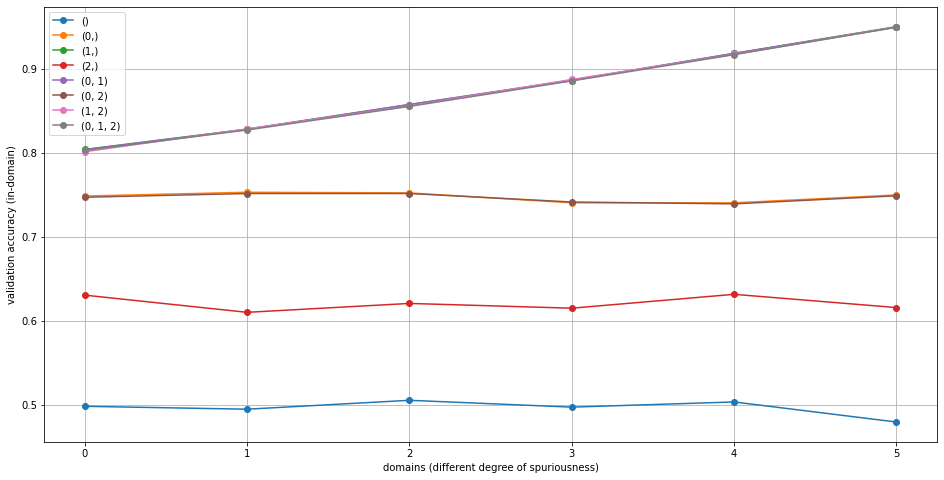

In [5]:
get_subset_valid_timeline(data_args,model_args,6,"syn.17.1",9)

In [ ]:
#Now getting the ood performance of each of the domain as compared to others
#This shouls be same as below ood perf value. Debug later
indo_vacc,ood_vacc = evaluate_ood_indo_performance(data_args,model_args,6,"syn.18.0",9)

In [18]:
dim0_mean,dim0_std,dim0_weights,ood_perf = get_dim_std(data_args,model_args,6,"syn.18.0",9)

Flipping the labels of: 500 many variable
num_0:1002	num_1:998
Flipping the labels of: 500 many variable
num_0:974	num_1:1026
Flipping the labels of: 500 many variable
num_0:986	num_1:1014
Flipping the labels of: 500 many variable
num_0:1046	num_1:954
Flipping the labels of: 500 many variable
num_0:1006	num_1:994
Flipping the labels of: 500 many variable
num_0:968	num_1:1032


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


RESET_VACC: 0.0
cat_indo:(0.0,)	cat_ood:(0.0,)	celoss:0.41115	vacc:0.74194
RESET_VACC: 0.0
cat_indo:(0.0,)	cat_ood:(0.16,)	celoss:0.41115	vacc:0.80645
RESET_VACC: 0.0
cat_indo:(0.0,)	cat_ood:(0.32,)	celoss:0.41115	vacc:0.78908
RESET_VACC: 0.0
cat_indo:(0.0,)	cat_ood:(0.48,)	celoss:0.41115	vacc:0.76179
RESET_VACC: 0.0
cat_indo:(0.0,)	cat_ood:(0.64,)	celoss:0.41115	vacc:0.78908
RESET_VACC: 0.0
cat_indo:(0.0,)	cat_ood:(0.8,)	celoss:0.41115	vacc:0.81390
RESET_VACC: 0.0
cat_indo:(0.16,)	cat_ood:(0.0,)	celoss:0.41115	vacc:0.73697
RESET_VACC: 0.0
cat_indo:(0.16,)	cat_ood:(0.16,)	celoss:0.41115	vacc:0.83623
RESET_VACC: 0.0
cat_indo:(0.16,)	cat_ood:(0.32,)	celoss:0.41115	vacc:0.85608
RESET_VACC: 0.0
cat_indo:(0.16,)	cat_ood:(0.48,)	celoss:0.41115	vacc:0.85112
RESET_VACC: 0.0
cat_indo:(0.16,)	cat_ood:(0.64,)	celoss:0.41115	vacc:0.90571
RESET_VACC: 0.0
cat_indo:(0.16,)	cat_ood:(0.8,)	celoss:0.41115	vacc:0.95037
RESET_VACC: 0.0
cat_indo:(0.32,)	cat_ood:(0.0,)	celoss:0.41115	vacc:0.73697
RESET_VACC

([<matplotlib.axis.XTick at 0x7fa395be9ee0>,
 [Text(0, 0, '0'),
  Text(0, 1, '0'),
  Text(1, 0, '1'),
  Text(1, 1, '1'),
  Text(2, 0, '2'),
  Text(2, 1, '2'),
  Text(3, 0, '3'),
  Text(3, 1, '3'),
  Text(4, 0, '4'),
  Text(4, 1, '4'),
  Text(5, 0, '5'),
  Text(5, 1, '5')])

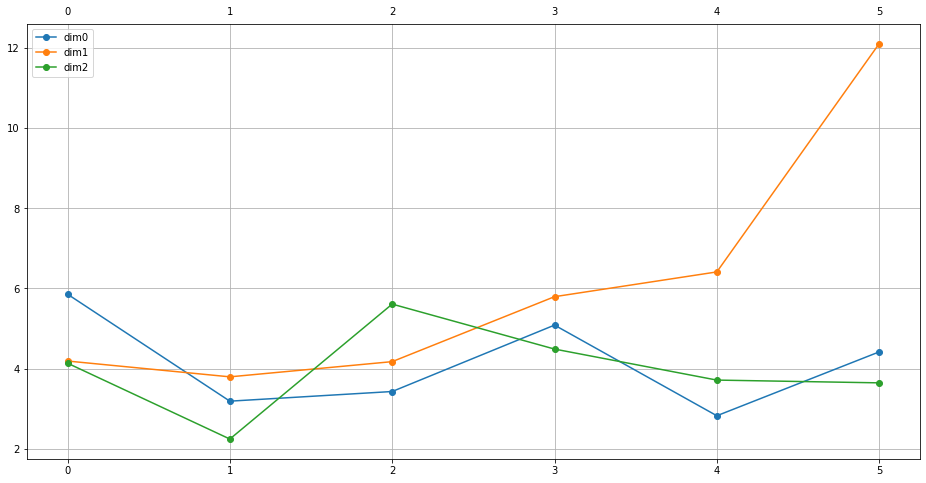

In [24]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
# fig,axes= plt.subplots(2,1)
dim_p_weights = dim0_weights
for didx in range(dim_p_weights.shape[0]):
    plt.plot(range(dim_p_weights.shape[1]),dim_p_weights[didx,:],"o-",label="dim{}".format(didx))

plt.legend()
plt.grid(b=True)
plt.xticks(range(dim_p_weights.shape[1]),range(dim_p_weights.shape[1]),visible=True)

<AxesSubplot:title={'center':'OOD performance in different domain'}, xlabel='domain'>

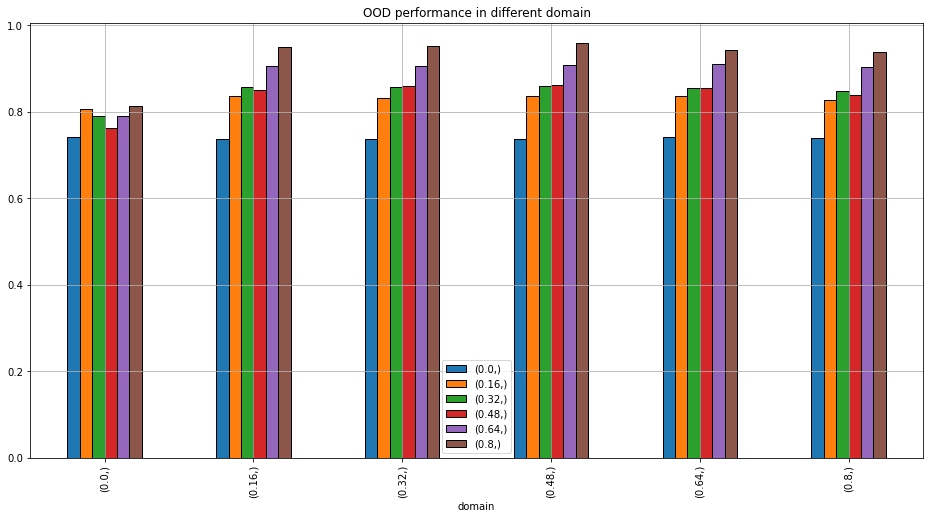

In [23]:
#Plotting the OOD performance
import pandas as pd
from collections import defaultdict
ood_df = pd.DataFrame(ood_perf)
ood_df.plot(x='domain',
        kind='bar',
        stacked=False,
        grid=True,
        title='OOD performance in different domain',
        edgecolor="k",
)

In [6]:
def get_weighted_imp_diff(imp_weights,ood_perf,rescale):
    '''
    imp_weights : [dim,num_cat]
    ood_perf    : { 
                        domains  : [cat1, cat2, ...]
                        cat1_perf: [cat1_clf_acc, cat2_clf_acc,...]
                        cat2_perf: [cat1_clf_acc, cat2_clf_acc,...]
                  }
    '''
    #Rescaling the importance weight to make them relative to each of the domain
    if rescale:
        imp_weights = imp_weights/np.sum(imp_weights,axis=0,keepdims=True)
    
    #We have to do this for each of the group (domain and all other diff domain perf)
    cat_list = ood_perf["domain"]
    domain_weight_diff_list = []
    for cidx,cat in enumerate(cat_list):
        #Now iterating over all the other domains
        indo_vacc = ood_perf[cat][cidx]
        weight_diff = np.zeros(imp_weights.shape[0])
        #Now getting the ood performance in different domain
        for tidx,tname in enumerate(cat_list):
            if tname==cat:
                continue
            #Getting the vacc in of this doamin the the cat
            ood_vacc = ood_perf[tname][cidx]
            perf_diff = ood_vacc-indo_vacc #(ood_vacc<indo_vacc) #dont take into account if vacc is increasing
            
            #Now getting the different in the importance weight
            if(perf_diff<0.0):
                weight_diff = weight_diff + np.abs(perf_diff)*(imp_weights[:,tidx]-imp_weights[:,cidx]) #imp drop is needed
        
        #Saving the weight weighted weight difference
        domain_result = [cat] + weight_diff.tolist()
        domain_weight_diff_list.append(domain_result)
    
    #Now creatting a dataframe for the result
    wdiff_df = pd.DataFrame(domain_weight_diff_list,
                            columns = ["domain"] + ["dim{}".format(didx) for didx in range(imp_weights.shape[0])]
            )
    wdiff_df.plot(
        x='domain',
        kind='bar',
        stacked=False,
        grid=True,
        title='Weighted-Delta in importance weight based on OOD perf',
        edgecolor="k",
    )
    
    return wdiff_df

,domain,dim0,dim1,dim2
0,"(0.0,)",0.000000,0.000000,0.000000
1,"(0.16,)",0.264943,0.039172,0.187812
2,"(0.32,)",0.283268,-0.007589,-0.259152
3,"(0.48,)",0.044514,-0.252795,-0.096643
4,"(0.64,)",0.702485,-0.733060,0.114012
5,"(0.8,)",0.071261,-4.032972,0.202476


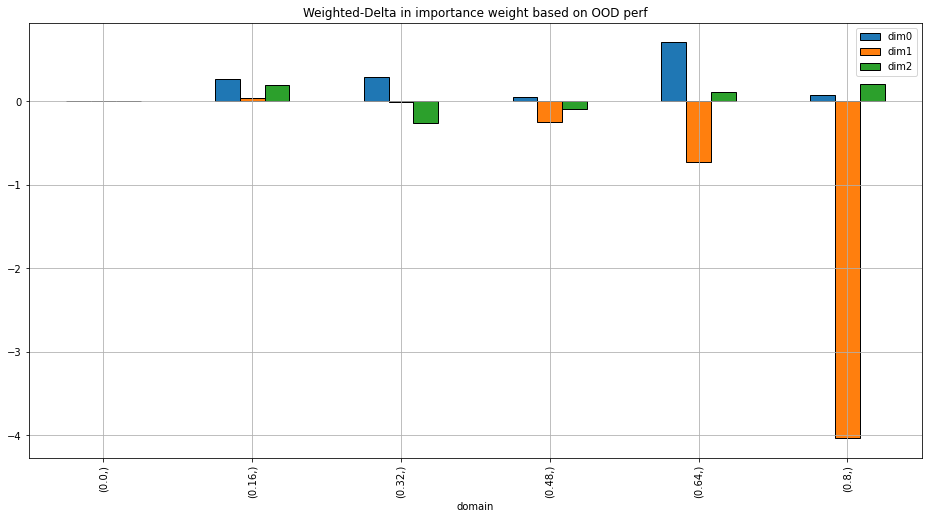

In [34]:
get_weighted_imp_diff(dim0_weights,ood_perf,False)

In [52]:
dim0_mean,dim0_std,dim0_weights,ood_perf = get_dim_std(data_args,model_args,8,"syn.19.1",49)

Flipping the labels of: 500 many variable
num_0:1006	num_1:994
Flipping the labels of: 500 many variable
num_0:988	num_1:1012
Flipping the labels of: 500 many variable
num_0:1000	num_1:1000
Flipping the labels of: 500 many variable
num_0:1016	num_1:984
Flipping the labels of: 500 many variable
num_0:1006	num_1:994
Flipping the labels of: 500 many variable
num_0:1024	num_1:976
Flipping the labels of: 500 many variable
num_0:1042	num_1:958
Flipping the labels of: 500 many variable
num_0:1012	num_1:988


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


RESET_VACC: 0.0
cat_indo:(0.0, 5)	cat_ood:(0.0, 5)	celoss:0.48863	vacc:0.74938
RESET_VACC: 0.0
cat_indo:(0.0, 5)	cat_ood:(0.1142857142857143, 5)	celoss:0.48863	vacc:0.72705
RESET_VACC: 0.0
cat_indo:(0.0, 5)	cat_ood:(0.2285714285714286, 1)	celoss:0.48863	vacc:0.65509
RESET_VACC: 0.0
cat_indo:(0.0, 5)	cat_ood:(0.34285714285714286, 5)	celoss:0.48863	vacc:0.73449
RESET_VACC: 0.0
cat_indo:(0.0, 5)	cat_ood:(0.4571428571428572, 4)	celoss:0.48863	vacc:0.67742
RESET_VACC: 0.0
cat_indo:(0.0, 5)	cat_ood:(0.5714285714285715, 5)	celoss:0.48863	vacc:0.74938
RESET_VACC: 0.0
cat_indo:(0.0, 5)	cat_ood:(0.6857142857142857, 1)	celoss:0.48863	vacc:0.66998
RESET_VACC: 0.0
cat_indo:(0.0, 5)	cat_ood:(0.8, 5)	celoss:0.48863	vacc:0.72953
RESET_VACC: 0.0
cat_indo:(0.1142857142857143, 5)	cat_ood:(0.0, 5)	celoss:0.48863	vacc:0.74442
RESET_VACC: 0.0
cat_indo:(0.1142857142857143, 5)	cat_ood:(0.1142857142857143, 5)	celoss:0.48863	vacc:0.77419
RESET_VACC: 0.0
cat_indo:(0.1142857142857143, 5)	cat_ood:(0.22857142857142

([<matplotlib.axis.XTick at 0x7fe7e5c38220>,
 [Text(0, 0, '(0.0, 5)'),
  Text(0, 1, '(0.0, 5)'),
  Text(1, 0, '(0.1142857142857143, 5)'),
  Text(1, 1, '(0.1142857142857143, 5)'),
  Text(2, 0, '(0.2285714285714286, 1)'),
  Text(2, 1, '(0.2285714285714286, 1)'),
  Text(3, 0, '(0.34285714285714286, 5)'),
  Text(3, 1, '(0.34285714285714286, 5)'),
  Text(4, 0, '(0.4571428571428572, 4)'),
  Text(4, 1, '(0.4571428571428572, 4)'),
  Text(5, 0, '(0.5714285714285715, 5)'),
  Text(5, 1, '(0.5714285714285715, 5)'),
  Text(6, 0, '(0.6857142857142857, 1)'),
  Text(6, 1, '(0.6857142857142857, 1)'),
  Text(7, 0, '(0.8, 5)'),
  Text(7, 1, '(0.8, 5)')])

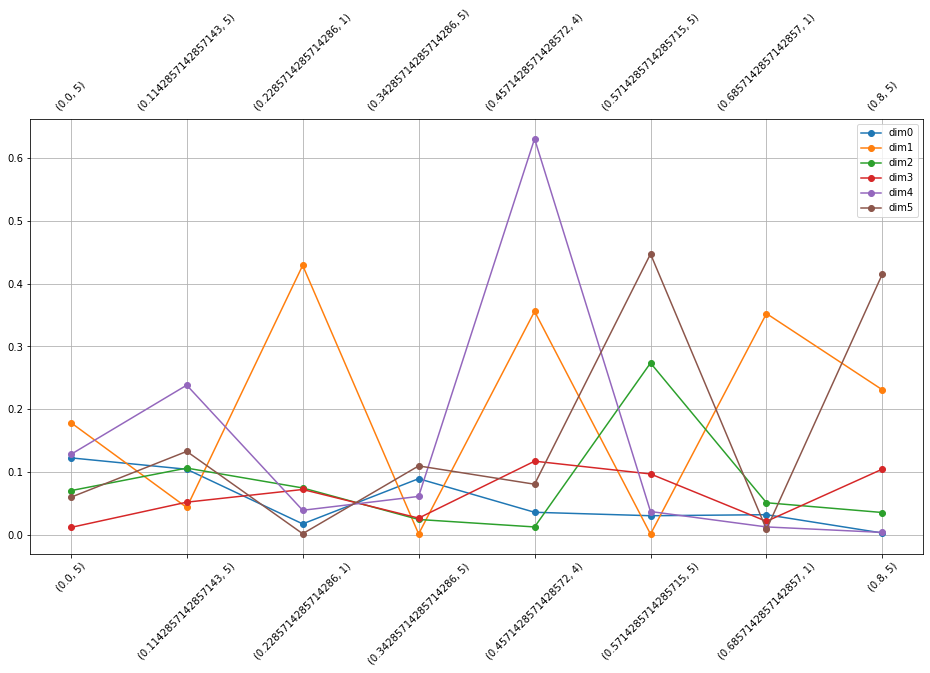

In [53]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 8]
# fig,axes= plt.subplots(2,1)
dim_p_weights = dim0_weights
for didx in range(dim_p_weights.shape[0]):
    plt.plot(range(dim_p_weights.shape[1]),dim_p_weights[didx,:],"o-",label="dim{}".format(didx))

plt.legend()
plt.grid(b=True)
plt.xticks(range(dim_p_weights.shape[1]),ood_perf["domain"],rotation=45,visible=True)

<AxesSubplot:title={'center':'OOD performance in different domain'}, xlabel='domain'>

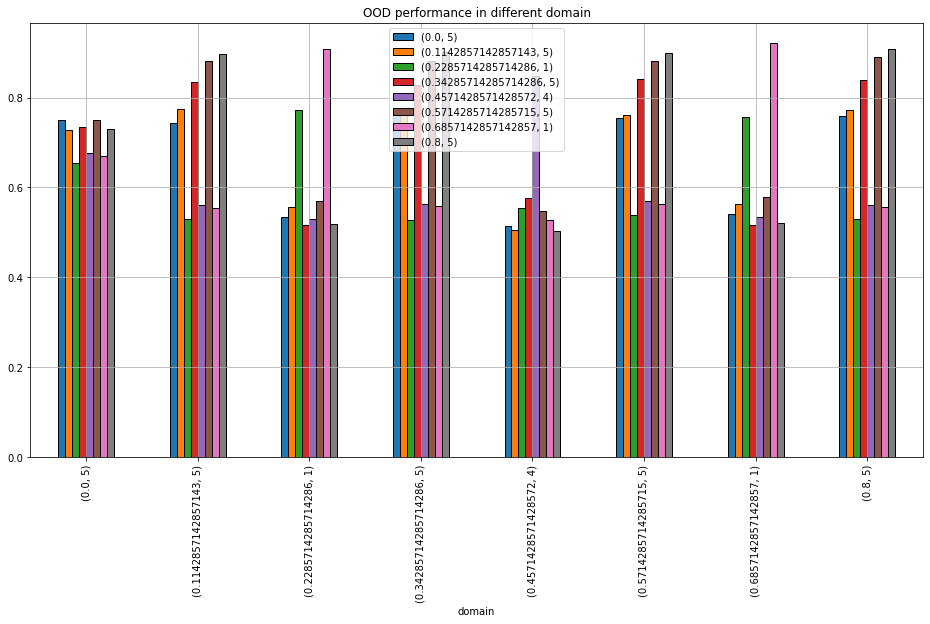

In [54]:
#Plotting the OOD performance
import pandas as pd
from collections import defaultdict
ood_df = pd.DataFrame(ood_perf)
ood_df.plot(x='domain',
        kind='bar',
        stacked=False,
        grid=True,
        title='OOD performance in different domain',
        edgecolor="k",
)

,domain,dim0,dim1,dim2,dim3,dim4,dim5
0,"(0.0, 5)",-0.026617,0.045506,-0.005853,0.017036,0.017630,0.001411
1,"(0.1142857142857143, 5)",-0.051218,0.232633,-0.040959,0.010910,-0.017872,-0.072633
2,"(0.2285714285714286, 1)",0.065599,-0.405944,0.008112,-0.006379,0.202902,0.282920
3,"(0.34285714285714286, 5)",-0.048236,0.331676,0.026882,0.036816,0.146076,-0.069530
4,"(0.4571428571428572, 4)",0.047341,-0.392128,0.171724,-0.136904,-1.225300,0.198202
5,"(0.5714285714285715, 5)",0.020599,0.395674,-0.275396,-0.045064,0.213471,-0.505563
6,"(0.6857142857142857, 1)",0.070286,-0.473092,0.075188,0.113776,0.392719,0.444142
7,"(0.8, 5)",0.065455,0.107730,0.030450,-0.063761,0.289201,-0.527921


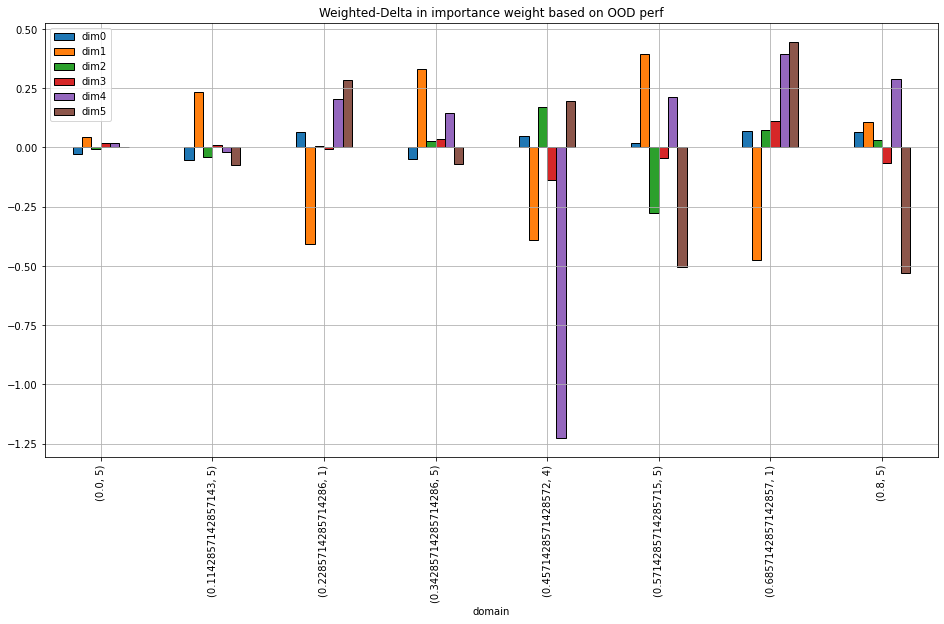

In [55]:
get_weighted_imp_diff(dim0_weights,ood_perf,False)